# MOVIELENS大作业

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
# Reading ratings file
ratings = pd.read_csv('./ratings2.csv',  encoding='latin-1', usecols=['user_id', 'movie_id', 'rating', 'timestamp'])

# Reading users file
users = pd.read_csv('./users.csv', 
                    encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('./movies.csv',  encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

# Reading movies info file
movies_info = pd.read_csv('./info.csv',  encoding='latin-1', usecols=['id', 'name', 'genre','intro','directors','starts', 'release_time'])
movies_info.rename(columns ={ 'id':'movie_id', 'starts': 'stars'}, inplace = True)

## 一、传统偏好发现

### 不同职业观影者的偏好分析

In [2]:
# 筛选出观影人次大于300的电影
popular = ratings['movie_id'].value_counts()
popular = popular[popular > 300]
popular = popular.rename('count')
popular = popular.rename_axis('movie_id')
print("Popular:")
display(popular)

Popular:


movie_id
2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
2404     301
1845     301
1012     301
535      301
2363     301
Name: count, Length: 1053, dtype: int64

In [3]:
# 将用户信息与评分信息结合起来
occu_users = pd.merge(users, ratings, on='user_id', how='outer')
occu_users = occu_users[occu_users['movie_id'].isin(popular.index)] # 只保留popular的电影
print('Users\' information with movie ratings:')
display(occu_users.head())

Users' information with movie ratings:


user_id gender zipcode  age_desc      occ_desc  movie_id  rating  timestamp
0        1      F   48067  Under 18  K-12 student      1193       5  978300760
1        1      F   48067  Under 18  K-12 student       661       3  978302109
2        1      F   48067  Under 18  K-12 student       914       3  978301968
3        1      F   48067  Under 18  K-12 student      3408       4  978300275
4        1      F   48067  Under 18  K-12 student      2355       5  978824291

In [4]:
# 统计每种职业的人数
occupations = occu_users['occ_desc'].unique() # 获取所有职业
occupations_counts = users.groupby('occ_desc').count().iloc[:, 0].rename('occupation total number').reset_index()
occupations_counts.columns = ['occupation', 'occupation total number']
print('Each occupation\'s number:')
display(occupations_counts)

Each occupation's number:


occupation  occupation total number
0             K-12 student                      195
1        academic/educator                      528
2                   artist                      267
3           clerical/admin                      173
4     college/grad student                      759
5         customer service                      112
6       doctor/health care                      236
7     executive/managerial                      679
8                   farmer                       17
9                homemaker                       92
10                  lawyer                      129
11  other or not specified                      711
12              programmer                      388
13                 retired                      142
14         sales/marketing                      302
15               scientist                      144
16           self-employed                      241
17     technician/engineer                      502
18     tradesman/craftsman                       70
19              unemployed                       72
20                  writer                      281

In [5]:
# 将用户-评分信息按照职业划分
users_dict = {}
for occupation in occupations:
    users_dict[occupation] = occu_users[occu_users['occ_desc'] == occupation]
print('Example: doctor/health care:')
display(users_dict[occupation].head())

Example: doctor/health care:


user_id gender zipcode age_desc            occ_desc  movie_id  rating  \
16197      128      M   37922      56+  doctor/health care      1249       5   
16198      128      M   37922      56+  doctor/health care      1250       5   
16200      128      M   37922      56+  doctor/health care      1282       5   
16201      128      M   37922      56+  doctor/health care      2160       5   
16202      128      M   37922      56+  doctor/health care      2253       4   

       timestamp  
16197  977434389  
16198  977434342  
16200  977434389  
16201  977434389  
16202  977434184

In [6]:
# 计算每个职业的观影者对每部电影的平均打分以及每个职业观看每部电影的人数
mean_ratings_dict = {}
for occupation in occupations:
    mean_ratings_dict[occupation] = users_dict[occupation].groupby('movie_id')['rating'].mean().reset_index()
    watcher_count = users_dict[occupation].groupby('movie_id').count()
    watcher_count = watcher_count.iloc[:, 0]
    watcher_count = watcher_count.reset_index()
    watcher_count.columns = ['movie_id', 'number']
    mean_ratings_dict[occupation] = pd.merge(mean_ratings_dict[occupation], watcher_count, on='movie_id', how='outer')

print('Example: doctor/health care:')
display(mean_ratings_dict[occupation].head())

Example: doctor/health care:


movie_id    rating  number
0         1  4.394737      76
1         2  3.107143      28
2         3  2.714286      21
3         6  4.068966      29
4         7  3.214286      14

In [7]:
# 合并以上数据
frames = []
for occupation, series in mean_ratings_dict.items():
    df = series
    df.columns = ['movie_id', 'rating', 'number']
    df['occupation'] = occupation
    frames.append(df)
all_ratings = pd.concat(frames)
all_ratings = all_ratings.reset_index()
all_ratings = all_ratings.merge(occupations_counts, on='occupation', how='outer')
print('all_ratings:')
all_ratings.head()

all_ratings:


index  movie_id    rating  number    occupation  occupation total number
0      0         1  3.904255      94  K-12 student                      195
1      1         2  3.322581      31  K-12 student                      195
2      2         3  3.600000      15  K-12 student                      195
3      3         6  4.250000      16  K-12 student                      195
4      4         7  3.500000      12  K-12 student                      195

In [8]:
# 计算每部电影的平均评分
overall_mean = all_ratings.groupby('movie_id')['rating'].mean().rename('overall_rating')
# 把职业对电影的平均评分合并到all_ratings
all_ratings = all_ratings.merge(overall_mean, on='movie_id', how='outer')
print('all_ratings:')
all_ratings.head()

all_ratings:


index  movie_id    rating  number            occupation  \
0      0         1  3.904255      94          K-12 student   
1      0         1  4.229299     157     academic/educator   
2      0         1  4.000000      86                artist   
3      0         1  4.492537      67        clerical/admin   
4      0         1  4.040404     297  college/grad student   

   occupation total number  overall_rating  
0                      195        4.151042  
1                      528        4.151042  
2                      267        4.151042  
3                      173        4.151042  
4                      759        4.151042

In [9]:
# 计算差异并添加观影总人数到all_ratings
all_ratings['diff_from_avg'] = all_ratings['rating'] - all_ratings['overall_rating']
all_ratings = pd.merge(all_ratings, popular, on='movie_id', how='outer')
print('all_ratings:')
all_ratings.head()

all_ratings:


index  movie_id    rating  number            occupation  \
0      0         1  3.904255      94          K-12 student   
1      0         1  4.229299     157     academic/educator   
2      0         1  4.000000      86                artist   
3      0         1  4.492537      67        clerical/admin   
4      0         1  4.040404     297  college/grad student   

   occupation total number  overall_rating  diff_from_avg  count  
0                      195        4.151042      -0.246786   2077  
1                      528        4.151042       0.078258   2077  
2                      267        4.151042      -0.151042   2077  
3                      173        4.151042       0.341496   2077  
4                      759        4.151042      -0.110638   2077

In [10]:
# 计算评价函数: score = (职业平均评分rating - 平均评分overall_rating) * (该职业的总观影人数number / 观影总人数count + 2 * 该职业的总观影人数number / 该职业总人数occupation total number
w1 = 1
w2 = 2
all_ratings['score'] = all_ratings['diff_from_avg'] * (w1 * all_ratings['number'] / all_ratings['count'] + w2 * all_ratings['number'] / all_ratings['occupation total number'])
all_ratings = all_ratings.set_index('movie_id')
for occupation in occupations:
    score = all_ratings[all_ratings['occupation'] == occupation]
    score = score.drop(['index', 'rating', 'occupation', 'overall_rating'], axis=1)
print('Example: doctor/health care:')
display(score)

Example: doctor/health care:


number  occupation total number  diff_from_avg  count     score
movie_id                                                                 
1             76                      236       0.243695   2077  0.165873
2             28                      236      -0.065700    701 -0.018214
3             21                      236      -0.306814    478 -0.068082
6             29                      236       0.176449    940  0.048808
7             14                      236      -0.164260    458 -0.024509
...          ...                      ...            ...    ...       ...
3916          19                      236       0.223229    437  0.045649
3927          12                      236       0.264032    348  0.035955
3948          30                      236      -0.059601    862 -0.017227
3949           8                      236       0.056045    304  0.005275
3952          19                      236       0.319830    388  0.067160

[1053 rows x 5 columns]

In [11]:
# 筛选出每个职业前10名的电影，分别作为该职业偏好的电影
preferences = {}
for occupation in occupations:
    preferences[occupation] = all_ratings[all_ratings['occupation']==occupation].nlargest(10, 'score').reset_index()
    
for occupation in occupations:
    print(occupation, '最偏好的10部电影:')
    preference_detail = pd.merge(preferences[occupation], movies, on='movie_id', how='inner')
    preference_detail = preference_detail.drop(['movie_id', 'index', 'rating', 'occupation', 'overall_rating', 'diff_from_avg', 'count', 'number', 'occupation total number'], axis=1)
    preference_detail['rank'] = preference_detail.index.to_series().apply(lambda x: x+1)
    preference_detail = preference_detail.set_index('rank')
    display(preference_detail)

K-12 student 最偏好的10部电影:


score                                              title  \
rank                                                                
1     0.408380       Austin Powers: The Spy Who Shagged Me (1999)   
2     0.362344                                  Spaceballs (1987)   
3     0.358246                               Billy Madison (1995)   
4     0.342534                                   Big Daddy (1999)   
5     0.330416  Austin Powers: International Man of Mystery (1...   
6     0.314861   Star Wars: Episode I - The Phantom Menace (1999)   
7     0.294553                       Mission: Impossible 2 (2000)   
8     0.265733                        Me, Myself and Irene (2000)   
9     0.262665                                 Matrix, The (1999)   
10    0.260806                                   GoldenEye (1995)   

                               genres  
rank                                   
1                              Comedy  
2                       Comedy|Sci-Fi  
3                              Comedy  
4                              Comedy  
5                              Comedy  
6     Action|Adventure|Fantasy|Sci-Fi  
7                     Action|Thriller  
8                              Comedy  
9              Action|Sci-Fi|Thriller  
10          Action|Adventure|Thriller

self-employed 最偏好的10部电影:


score                                           title  \
rank                                                             
1     0.194809                          Terminator, The (1984)   
2     0.190978  Midnight in the Garden of Good and Evil (1997)   
3     0.177361            Star Trek: The Motion Picture (1979)   
4     0.174401                    2001: A Space Odyssey (1968)   
5     0.163745           Invasion of the Body Snatchers (1956)   
6     0.162302                     Boat, The (Das Boot) (1981)   
7     0.142248                      Saving Private Ryan (1998)   
8     0.141605                              Pushing Tin (1999)   
9     0.141104                                King Kong (1933)   
10    0.137962                                  Contact (1997)   

                             genres  
rank                                 
1            Action|Sci-Fi|Thriller  
2        Comedy|Crime|Drama|Mystery  
3           Action|Adventure|Sci-Fi  
4     Drama|Mystery|Sci-Fi|Thriller  
5                     Horror|Sci-Fi  
6                  Action|Drama|War  
7                  Action|Drama|War  
8                            Comedy  
9           Action|Adventure|Horror  
10                     Drama|Sci-Fi

scientist 最偏好的10部电影:


score                                      title  \
rank                                                        
1     0.293496                        Blade Runner (1982)   
2     0.263644     Monty Python and the Holy Grail (1974)   
3     0.257553                 Princess Bride, The (1987)   
4     0.216183     Nightmare Before Christmas, The (1993)   
5     0.215717  Star Wars: Episode IV - A New Hope (1977)   
6     0.186242                Being John Malkovich (1999)   
7     0.176037                     Man on the Moon (1999)   
8     0.163021                            Fantasia (1940)   
9     0.159641                        Office Space (1999)   
10    0.157473                      Eyes Wide Shut (1999)   

                               genres  
rank                                   
1                    Film-Noir|Sci-Fi  
2                              Comedy  
3     Action|Adventure|Comedy|Romance  
4           Children's|Comedy|Musical  
5     Action|Adventure|Fantasy|Sci-Fi  
6                              Comedy  
7                        Comedy|Drama  
8        Animation|Children's|Musical  
9                      Comedy|Romance  
10                              Drama

executive/managerial 最偏好的10部电影:


score                             title  \
rank                                               
1     0.168482               Total Recall (1990)   
2     0.149482             Basic Instinct (1992)   
3     0.133360              Lethal Weapon (1987)   
4     0.128890                    Top Gun (1986)   
5     0.122209                  Firm, The (1993)   
6     0.120913                      Rocky (1976)   
7     0.119486  Hunt for Red October, The (1990)   
8     0.118926                 Die Hard 2 (1990)   
9     0.114292           Longest Day, The (1962)   
10    0.113007           Fatal Attraction (1987)   

                                genres  
rank                                    
1     Action|Adventure|Sci-Fi|Thriller  
2                     Mystery|Thriller  
3            Action|Comedy|Crime|Drama  
4                       Action|Romance  
5                       Drama|Thriller  
6                         Action|Drama  
7                      Action|Thriller  
8                      Action|Thriller  
9                     Action|Drama|War  
10                            Thriller

writer 最偏好的10部电影:


score                                       title  \
rank                                                         
1     0.252018                           Annie Hall (1977)   
2     0.224924                             Rushmore (1998)   
3     0.224134                           Limey, The (1999)   
4     0.203805             Who Framed Roger Rabbit? (1988)   
5     0.202722                        Grifters, The (1990)   
6     0.201555                   Thin Red Line, The (1998)   
7     0.198918                            Manhattan (1979)   
8     0.192039                2001: A Space Odyssey (1968)   
9     0.167237  Mad Max 2 (a.k.a. The Road Warrior) (1981)   
10    0.162921              Godfather: Part II, The (1974)   

                             genres  
rank                                 
1                    Comedy|Romance  
2                            Comedy  
3                Action|Crime|Drama  
4     Adventure|Animation|Film-Noir  
5             Crime|Drama|Film-Noir  
6                  Action|Drama|War  
7              Comedy|Drama|Romance  
8     Drama|Mystery|Sci-Fi|Thriller  
9                     Action|Sci-Fi  
10               Action|Crime|Drama

homemaker 最偏好的10部电影:


score                           title  \
rank                                             
1     0.416948                  Sabrina (1995)   
2     0.392109             Mary Poppins (1964)   
3     0.380127             Pretty Woman (1990)   
4     0.373387                   Grease (1978)   
5     0.332651            Dirty Dancing (1987)   
6     0.316450       Lady and the Tramp (1955)   
7     0.290856   Independence Day (ID4) (1996)   
8     0.290373                  Titanic (1997)   
9     0.272884  While You Were Sleeping (1995)   
10    0.258644          You've Got Mail (1998)   

                                           genres  
rank                                               
1                                  Comedy|Romance  
2                       Children's|Comedy|Musical  
3                                  Comedy|Romance  
4                          Comedy|Musical|Romance  
5                                 Musical|Romance  
6     Animation|Children's|Comedy|Musical|Romance  
7                               Action|Sci-Fi|War  
8                                   Drama|Romance  
9                                  Comedy|Romance  
10                                 Comedy|Romance

academic/educator 最偏好的10部电影:


score                                     title             genres
rank                                                                       
1     0.267556                Shakespeare in Love (1998)     Comedy|Romance
2     0.155074                          Lone Star (1996)      Drama|Mystery
3     0.146853  Red Violin, The (Le Violon rouge) (1998)      Drama|Mystery
4     0.127778                Maltese Falcon, The (1941)  Film-Noir|Mystery
5     0.127154                   Chariots of Fire (1981)              Drama
6     0.111919            When Harry Met Sally... (1989)     Comedy|Romance
7     0.107959                   Crying Game, The (1992)  Drama|Romance|War
8     0.107878                 Dangerous Liaisons (1988)      Drama|Romance
9     0.104882                            Sleeper (1973)      Comedy|Sci-Fi
10    0.101211                            Rebecca (1940)   Romance|Thriller

programmer 最偏好的10部电影:


score                                              title  \
rank                                                                
1     0.294033  Star Wars: Episode V - The Empire Strikes Back...   
2     0.251578                                     Contact (1997)   
3     0.236562          Star Wars: Episode IV - A New Hope (1977)   
4     0.233591                                 Mystery Men (1999)   
5     0.224657                                 Matrix, The (1999)   
6     0.219633                                       Alien (1979)   
7     0.219520                                     Gattaca (1997)   
8     0.214922                                Office Space (1999)   
9     0.185857                                Blade Runner (1982)   
10    0.177936                                Pulp Fiction (1994)   

                                 genres  
rank                                     
1     Action|Adventure|Drama|Sci-Fi|War  
2                          Drama|Sci-Fi  
3       Action|Adventure|Fantasy|Sci-Fi  
4               Action|Adventure|Comedy  
5                Action|Sci-Fi|Thriller  
6         Action|Horror|Sci-Fi|Thriller  
7                 Drama|Sci-Fi|Thriller  
8                        Comedy|Romance  
9                      Film-Noir|Sci-Fi  
10                          Crime|Drama

technician/engineer 最偏好的10部电影:


score                                              title  \
rank                                                                
1     0.315095                                 Matrix, The (1999)   
2     0.231373                  Terminator 2: Judgment Day (1991)   
3     0.219053                             Terminator, The (1984)   
4     0.203709                         Saving Private Ryan (1998)   
5     0.167020  Star Wars: Episode VI - Return of the Jedi (1983)   
6     0.165691                     Raiders of the Lost Ark (1981)   
7     0.165432                              Grumpy Old Men (1993)   
8     0.156372  Star Wars: Episode V - The Empire Strikes Back...   
9     0.147545                                Animal House (1978)   
10    0.142063                                      Aliens (1986)   

                                   genres  
rank                                       
1                  Action|Sci-Fi|Thriller  
2                  Action|Sci-Fi|Thriller  
3                  Action|Sci-Fi|Thriller  
4                        Action|Drama|War  
5     Action|Adventure|Romance|Sci-Fi|War  
6                        Action|Adventure  
7                                  Comedy  
8       Action|Adventure|Drama|Sci-Fi|War  
9                                  Comedy  
10             Action|Sci-Fi|Thriller|War

other or not specified 最偏好的10部电影:


score                                              title  \
rank                                                                
1     0.180351                                   Tommy Boy (1995)   
2     0.141234                                      Friday (1995)   
3     0.137699                               Boogie Nights (1997)   
4     0.136851                                Office Space (1999)   
5     0.135181                               Dumb & Dumber (1994)   
6     0.124203                      Brady Bunch Movie, The (1995)   
7     0.123462                                 Matrix, The (1999)   
8     0.119299                                  Doors, The (1991)   
9     0.111658                               Private Parts (1997)   
10    0.110803  Austin Powers: International Man of Mystery (1...   

                      genres  
rank                          
1                     Comedy  
2                     Comedy  
3                      Drama  
4             Comedy|Romance  
5                     Comedy  
6                     Comedy  
7     Action|Sci-Fi|Thriller  
8              Drama|Musical  
9               Comedy|Drama  
10                    Comedy

clerical/admin 最偏好的10部电影:


score                        title                        genres
rank                                                                     
1     0.281769   Wedding Singer, The (1998)                Comedy|Romance
2     0.275527             Toy Story (1995)   Animation|Children's|Comedy
3     0.223773         Stuart Little (1999)             Children's|Comedy
4     0.216046      Meet the Parents (2000)                        Comedy
5     0.196056              Clueless (1995)                Comedy|Romance
6     0.194224   Edward Scissorhands (1990)                 Drama|Romance
7     0.191899  Beauty and the Beast (1991)  Animation|Children's|Musical
8     0.191304         Jurassic Park (1993)       Action|Adventure|Sci-Fi
9     0.188908         Trainspotting (1996)                         Drama
10    0.188699      Sixth Sense, The (1999)                      Thriller

sales/marketing 最偏好的10部电影:


score                                         title  \
rank                                                           
1     0.166633                              Gladiator (2000)   
2     0.161048                   English Patient, The (1996)   
3     0.160074                               Swingers (1996)   
4     0.159023              Silence of the Lambs, The (1991)   
5     0.156992                        American Beauty (1999)   
6     0.153370           Fast Times at Ridgemont High (1982)   
7     0.152102   Life Is Beautiful (La Vita Ã¨ bella) (1997)   
8     0.146015  Austin Powers: The Spy Who Shagged Me (1999)   
9     0.144151                    Saving Private Ryan (1998)   
10    0.143981                             Braveheart (1995)   

                 genres  
rank                     
1          Action|Drama  
2     Drama|Romance|War  
3          Comedy|Drama  
4        Drama|Thriller  
5          Comedy|Drama  
6                Comedy  
7          Comedy|Drama  
8                Comedy  
9      Action|Drama|War  
10     Action|Drama|War

college/grad student 最偏好的10部电影:


score                                              title  \
rank                                                                
1     0.278665                                Office Space (1999)   
2     0.273290                                 Matrix, The (1999)   
3     0.265603                                  Spaceballs (1987)   
4     0.264320                             American Beauty (1999)   
5     0.257981                                        Clue (1985)   
6     0.254931                                  Fight Club (1999)   
7     0.246621       Austin Powers: The Spy Who Shagged Me (1999)   
8     0.238390                                Goonies, The (1985)   
9     0.228330                           Big Lebowski, The (1998)   
10    0.225985  Austin Powers: International Man of Mystery (1...   

                             genres  
rank                                 
1                    Comedy|Romance  
2            Action|Sci-Fi|Thriller  
3                     Comedy|Sci-Fi  
4                      Comedy|Drama  
5                    Comedy|Mystery  
6                             Drama  
7                            Comedy  
8      Adventure|Children's|Fantasy  
9     Comedy|Crime|Mystery|Thriller  
10                           Comedy

lawyer 最偏好的10部电影:


score                           title  \
rank                                             
1     0.328647               Casablanca (1942)   
2     0.294505  Godfather: Part II, The (1974)   
3     0.245228       Do the Right Thing (1989)   
4     0.222931     Fish Called Wanda, A (1988)   
5     0.191066      Princess Bride, The (1987)   
6     0.191056                 Hoosiers (1986)   
7     0.183321                   Clerks (1994)   
8     0.171851                Lone Star (1996)   
9     0.163885               Annie Hall (1977)   
10    0.159643     Being John Malkovich (1999)   

                               genres  
rank                                   
1                   Drama|Romance|War  
2                  Action|Crime|Drama  
3                        Comedy|Drama  
4                              Comedy  
5     Action|Adventure|Comedy|Romance  
6                               Drama  
7                              Comedy  
8                       Drama|Mystery  
9                      Comedy|Romance  
10                             Comedy

farmer 最偏好的10部电影:


score                                         title  \
rank                                                           
1     0.527137                            Dragonheart (1996)   
2     0.493460                           Forrest Gump (1994)   
3     0.478971                          Groundhog Day (1993)   
4     0.456714                            Poltergeist (1982)   
5     0.451589                             Mummy, The (1999)   
6     0.441717             Terminator 2: Judgment Day (1991)   
7     0.434370                Gods Must Be Crazy, The (1980)   
8     0.424343             Die Hard: With a Vengeance (1995)   
9     0.423849  Willy Wonka and the Chocolate Factory (1971)   
10    0.423283                                 Aliens (1986)   

                                   genres  
rank                                       
1                Action|Adventure|Fantasy  
2                      Comedy|Romance|War  
3                          Comedy|Romance  
4                         Horror|Thriller  
5        Action|Adventure|Horror|Thriller  
6                  Action|Sci-Fi|Thriller  
7                                  Comedy  
8                         Action|Thriller  
9     Adventure|Children's|Comedy|Fantasy  
10             Action|Sci-Fi|Thriller|War

unemployed 最偏好的10部电影:


score                              title           genres
rank                                                              
1     0.318562    Blair Witch Project, The (1999)           Horror
2     0.289571                    Magnolia (1999)            Drama
3     0.286194         Clockwork Orange, A (1971)           Sci-Fi
4     0.283326        Natural Born Killers (1994)  Action|Thriller
5     0.242287     Pee-wee's Big Adventure (1985)           Comedy
6     0.240823                      Clerks (1994)           Comedy
7     0.227222              Reservoir Dogs (1992)   Crime|Thriller
8     0.226717                    Scream 2 (1997)  Horror|Thriller
9     0.226309           Leaving Las Vegas (1995)    Drama|Romance
10    0.218012  Nightmare on Elm Street, A (1984)           Horror

artist 最偏好的10部电影:


score                                          title  \
rank                                                            
1     0.225148                                      Pi (1998)   
2     0.215235                     Edward Scissorhands (1990)   
3     0.206522                      Planet of the Apes (1968)   
4     0.197613                           Trainspotting (1996)   
5     0.193638         Nightmare Before Christmas, The (1993)   
6     0.186016                                    Tron (1982)   
7     0.185938                 Pee-wee's Big Adventure (1985)   
8     0.181873                       Wizard of Oz, The (1939)   
9     0.181825                  Breakfast at Tiffany's (1961)   
10    0.170399  William Shakespeare's Romeo and Juliet (1996)   

                                  genres  
rank                                      
1                        Sci-Fi|Thriller  
2                          Drama|Romance  
3                          Action|Sci-Fi  
4                                  Drama  
5              Children's|Comedy|Musical  
6        Action|Adventure|Fantasy|Sci-Fi  
7                                 Comedy  
8     Adventure|Children's|Drama|Musical  
9                          Drama|Romance  
10                         Drama|Romance

tradesman/craftsman 最偏好的10部电影:


score                                              title  \
rank                                                                
1     0.373548                                  Braveheart (1995)   
2     0.359552  Star Wars: Episode VI - Return of the Jedi (1983)   
3     0.357528                                      Scream (1996)   
4     0.339778                         From Dusk Till Dawn (1996)   
5     0.310965                                Forrest Gump (1994)   
6     0.297328                        Natural Born Killers (1994)   
7     0.291088                  Interview with the Vampire (1994)   
8     0.271051                                       Blade (1998)   
9     0.258814                             American Beauty (1999)   
10    0.258586                         Legends of the Fall (1994)   

                                   genres  
rank                                       
1                        Action|Drama|War  
2     Action|Adventure|Romance|Sci-Fi|War  
3                         Horror|Thriller  
4     Action|Comedy|Crime|Horror|Thriller  
5                      Comedy|Romance|War  
6                         Action|Thriller  
7                            Drama|Horror  
8                 Action|Adventure|Horror  
9                            Comedy|Drama  
10              Drama|Romance|War|Western

customer service 最偏好的10部电影:


score                          title                           genres
rank                                                                          
1     0.282042             Beetlejuice (1988)                   Comedy|Fantasy
2     0.267308        Sixth Sense, The (1999)                         Thriller
3     0.225170              Predator 2 (1990)           Action|Sci-Fi|Thriller
4     0.216875                Gremlins (1984)                    Comedy|Horror
5     0.215968                  Aliens (1986)       Action|Sci-Fi|Thriller|War
6     0.215050    Nutty Professor, The (1996)    Comedy|Fantasy|Romance|Sci-Fi
7     0.214380    Me, Myself and Irene (2000)                           Comedy
8     0.212033                    Jaws (1975)                    Action|Horror
9     0.211524            Animal House (1978)                           Comedy
10    0.209912  Jewel of the Nile, The (1985)  Action|Adventure|Comedy|Romance

retired 最偏好的10部电影:


score                                  title  \
rank                                                    
1     0.235410              African Queen, The (1951)   
2     0.225964  Lost World: Jurassic Park, The (1997)   
3     0.219104              Gone with the Wind (1939)   
4     0.212639      E.T. the Extra-Terrestrial (1982)   
5     0.203488                 Erin Brockovich (2000)   
6     0.193266                Chariots of Fire (1981)   
7     0.173341           2001: A Space Odyssey (1968)   
8     0.168977              As Good As It Gets (1997)   
9     0.164354                           Shane (1953)   
10    0.160633            Grapes of Wrath, The (1940)   

                                genres  
rank                                    
1         Action|Adventure|Romance|War  
2     Action|Adventure|Sci-Fi|Thriller  
3                    Drama|Romance|War  
4      Children's|Drama|Fantasy|Sci-Fi  
5                                Drama  
6                                Drama  
7        Drama|Mystery|Sci-Fi|Thriller  
8                         Comedy|Drama  
9                        Drama|Western  
10                               Drama

doctor/health care 最偏好的10部电影:


score                              title  \
rank                                                
1     0.222818               Mars Attacks! (1996)   
2     0.212646  E.T. the Extra-Terrestrial (1982)   
3     0.205845                   Elizabeth (1998)   
4     0.203951         Legends of the Fall (1994)   
5     0.185849         Saving Private Ryan (1998)   
6     0.179628    River Runs Through It, A (1992)   
7     0.179059                     Top Gun (1986)   
8     0.175127            Fatal Attraction (1987)   
9     0.169712            Sixth Sense, The (1999)   
10    0.165873                   Toy Story (1995)   

                               genres  
rank                                   
1            Action|Comedy|Sci-Fi|War  
2     Children's|Drama|Fantasy|Sci-Fi  
3                               Drama  
4           Drama|Romance|War|Western  
5                    Action|Drama|War  
6                               Drama  
7                      Action|Romance  
8                            Thriller  
9                            Thriller  
10        Animation|Children's|Comedy

### 不同类型电影的职业偏好可视化

#### 数据预处理

In [12]:
data = pd.merge(ratings, users, how='outer')
data = pd.merge(data, movies, how='outer')
print('data:')
data.head()

data:


user_id  movie_id  rating    timestamp gender zipcode  age_desc  \
0      1.0         1     5.0  978824268.0      F   48067  Under 18   
1      6.0         1     4.0  978237008.0      F   55117     50-55   
2      8.0         1     4.0  978233496.0      M   11413     25-34   
3      9.0         1     5.0  978225952.0      M   61614     25-34   
4     10.0         1     5.0  978226474.0      F   95370     35-44   

              occ_desc             title                       genres  
0         K-12 student  Toy Story (1995)  Animation|Children's|Comedy  
1            homemaker  Toy Story (1995)  Animation|Children's|Comedy  
2           programmer  Toy Story (1995)  Animation|Children's|Comedy  
3  technician/engineer  Toy Story (1995)  Animation|Children's|Comedy  
4    academic/educator  Toy Story (1995)  Animation|Children's|Comedy

In [13]:
# 统计不同职业的评分记录数量
data_occupation = {} # 按照不同职业划分数据
occupation_count = {} # 不同职业的评分记录的条数
for occupation in occupations:
    data_occupation[occupation] = data[data.occ_desc == occupation]
    occupation_count[occupation] = data_occupation[occupation].shape[0]
print('每种职业的评分记录数量:')
display(occupation_count)

每种职业的评分记录数量:


{'K-12 student': 23290,
 'self-employed': 46021,
 'scientist': 22951,
 'executive/managerial': 105425,
 'writer': 60397,
 'homemaker': 11345,
 'academic/educator': 85351,
 'programmer': 57214,
 'technician/engineer': 72816,
 'other or not specified': 130499,
 'clerical/admin': 31623,
 'sales/marketing': 49109,
 'college/grad student': 131032,
 'lawyer': 20563,
 'farmer': 2706,
 'unemployed': 14904,
 'artist': 50068,
 'tradesman/craftsman': 12086,
 'customer service': 21850,
 'retired': 13754,
 'doctor/health care': 37205}

#### 将genres进行split操作，构建描述矩阵

In [14]:
# 看看总共有多少个风格
genre_list = []
for i in movies.genres:
    genre = i.split(sep='|')
    genre_list += genre
genre_list = list(set(genre_list))
genre_list

['Horror',
 'War',
 'Thriller',
 'Animation',
 'Action',
 'Drama',
 'Comedy',
 'Crime',
 'Sci-Fi',
 'Fantasy',
 'Documentary',
 'Film-Noir',
 "Children's",
 'Romance',
 'Mystery',
 'Western',
 'Musical',
 'Adventure']

In [15]:
# 统计每个电影的风格
num_movies = movies.shape[0]
for genre in genre_list:
    movies[genre] = 0
for i in movies.index:
    genre = movies.loc[i].genres.split(sep='|')
    for j in genre:
        movies[j][i] = 1
movies.head()

movie_id                               title                        genres  \
0         1                    Toy Story (1995)   Animation|Children's|Comedy   
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy   
2         3             Grumpier Old Men (1995)                Comedy|Romance   
3         4            Waiting to Exhale (1995)                  Comedy|Drama   
4         5  Father of the Bride Part II (1995)                        Comedy   

   Horror  War  Thriller  Animation  Action  Drama  Comedy  ...  Sci-Fi  \
0       0    0         0          1       0      0       1  ...       0   
1       0    0         0          0       0      0       0  ...       0   
2       0    0         0          0       0      0       1  ...       0   
3       0    0         0          0       0      1       1  ...       0   
4       0    0         0          0       0      0       1  ...       0   

   Fantasy  Documentary  Film-Noir  Children's  Romance  Mystery  Western  \
0        0            0          0           1        0        0        0   
1        1            0          0           1        0        0        0   
2        0            0          0           0        1        0        0   
3        0            0          0           0        0        0        0   
4        0            0          0           0        0        0        0   

   Musical  Adventure  
0        0          0  
1        0          1  
2        0          0  
3        0          0  
4        0          0  

[5 rows x 21 columns]

In [16]:
# 将电影信息、评分信息和用户信息结合
data_2 = pd.merge(ratings, users, how='outer')
data_2 = pd.merge(data_2, movies, how='outer')
print('data2:', data_2.shape)
display(data_2.head())

data2: (1000386, 28)


user_id  movie_id  rating    timestamp gender zipcode  age_desc  \
0      1.0         1     5.0  978824268.0      F   48067  Under 18   
1      6.0         1     4.0  978237008.0      F   55117     50-55   
2      8.0         1     4.0  978233496.0      M   11413     25-34   
3      9.0         1     5.0  978225952.0      M   61614     25-34   
4     10.0         1     5.0  978226474.0      F   95370     35-44   

              occ_desc             title                       genres  ...  \
0         K-12 student  Toy Story (1995)  Animation|Children's|Comedy  ...   
1            homemaker  Toy Story (1995)  Animation|Children's|Comedy  ...   
2           programmer  Toy Story (1995)  Animation|Children's|Comedy  ...   
3  technician/engineer  Toy Story (1995)  Animation|Children's|Comedy  ...   
4    academic/educator  Toy Story (1995)  Animation|Children's|Comedy  ...   

   Sci-Fi  Fantasy  Documentary  Film-Noir  Children's  Romance  Mystery  \
0       0        0            0          0           1        0        0   
1       0        0            0          0           1        0        0   
2       0        0            0          0           1        0        0   
3       0        0            0          0           1        0        0   
4       0        0            0          0           1        0        0   

   Western  Musical  Adventure  
0        0        0          0  
1        0        0          0  
2        0        0          0  
3        0        0          0  
4        0        0          0  

[5 rows x 28 columns]

In [17]:
# 将data_2按照职业划分
data_2_occupation = {}
for occupation in occupations:
    data_2_occupation[occupation] = data_2[data_2.occ_desc==occupation]
print('Example: doctor/health care:')
display(data_2_occupation[occupation].head())

Example: doctor/health care:


user_id  movie_id  rating    timestamp gender zipcode age_desc  \
84     237.0         1     4.0  976761905.0      M   46835    25-34   
128    385.0         1     5.0  976300183.0      M   68131    25-34   
130    389.0         1     5.0  976298977.0      M   68128    25-34   
178    549.0         1     5.0  976070010.0      M   53217    25-34   
192    590.0         1     5.0  975913115.0      F   98032    35-44   

               occ_desc             title                       genres  ...  \
84   doctor/health care  Toy Story (1995)  Animation|Children's|Comedy  ...   
128  doctor/health care  Toy Story (1995)  Animation|Children's|Comedy  ...   
130  doctor/health care  Toy Story (1995)  Animation|Children's|Comedy  ...   
178  doctor/health care  Toy Story (1995)  Animation|Children's|Comedy  ...   
192  doctor/health care  Toy Story (1995)  Animation|Children's|Comedy  ...   

     Sci-Fi  Fantasy  Documentary  Film-Noir  Children's  Romance  Mystery  \
84        0        0            0          0           1        0        0   
128       0        0            0          0           1        0        0   
130       0        0            0          0           1        0        0   
178       0        0            0          0           1        0        0   
192       0        0            0          0           1        0        0   

     Western  Musical  Adventure  
84         0        0          0  
128        0        0          0  
130        0        0          0  
178        0        0          0  
192        0        0          0  

[5 rows x 28 columns]

In [18]:
# 初始化一个用于对比职业不同风格差异的表格
column1 = []
for occupation in occupations:
    column1.append(occupation)
    column1.append(occupation)
    column1.append(occupation)
    column1.append(occupation)
column2 = ['mean', 'std', 'count', 'portion'] * len(occupations)
df_2 = pd.DataFrame(np.zeros((len(genre_list), len(column1))), index=genre_list, columns=[column1, column2])
df_2

K-12 student                    self-employed                     \
                    mean  std count portion          mean  std count portion   
Horror               0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   
War                  0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   
Thriller             0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   
Animation            0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   
Action               0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   
Drama                0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   
Comedy               0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   
Crime                0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   
Sci-Fi               0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   
Fantasy              0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   
Documentary          0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   
Film-Noir            0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   
Children's           0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   
Romance              0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   
Mystery              0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   
Western              0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   
Musical              0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   
Adventure            0.0  0.0   0.0     0.0           0.0  0.0   0.0     0.0   

            scientist       ... customer service         retired             \
                 mean  std  ...            count portion    mean  std count   
Horror            0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   
War               0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   
Thriller          0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   
Animation         0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   
Action            0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   
Drama             0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   
Comedy            0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   
Crime             0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   
Sci-Fi            0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   
Fantasy           0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   
Documentary       0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   
Film-Noir         0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   
Children's        0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   
Romance           0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   
Mystery           0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   
Western           0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   
Musical           0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   
Adventure         0.0  0.0  ...              0.0     0.0     0.0  0.0   0.0   

                    doctor/health care                     
            portion               mean  std count portion  
Horror          0.0                0.0  0.0   0.0     0.0  
War             0.0                0.0  0.0   0.0     0.0  
Thriller        0.0                0.0  0.0   0.0     0.0  
Animation       0.0                0.0  0.0   0.0     0.0  
Action          0.0                0.0  0.0   0.0     0.0  
Drama           0.0                0.0  0.0   0.0     0.0  
Comedy          0.0                0.0  0.0   0.0     0.0  
Crime           0.0                0.0  0.0   0.0     0.0  
Sci-Fi          0.0                0.0  0.0   0.0     0.0  
Fantasy         0.0                0.0  0.0   0.0     0.0  
Documentary     0.0                0.0  0.0   0.0     0.0  
Film-Noir       0.0                0.0  0.0   0.0 

In [19]:
# 收集每个风格的均值，分风格将数据归一化；同时收集每个genre中各个职业的评分数据
for occupation in occupations:
    for genre in genre_list:
        tmp = data_2_occupation[occupation][data_2_occupation[occupation][genre] == 1]
        occupation_mean = tmp['rating'].mean()
        occupation_std = tmp['rating'].std()
        df_2.loc[genre, (occupation, 'mean')] = occupation_mean
        df_2.loc[genre, (occupation, 'std')] = occupation_std
        df_2.loc[genre, (occupation, 'count')] = tmp.shape[0]
        df_2.loc[genre, (occupation, 'portion')] = df_2.loc[genre, (occupation, 'count')] / occupation_count[occupation]
df_2

K-12 student                             self-employed            \
                    mean       std   count   portion          mean       std   
Horror          3.237795  1.352573  1905.0  0.081795      3.266436  1.172127   
War             3.880144  1.174791  1385.0  0.059468      3.926107  1.023735   
Thriller        3.554131  1.215418  4212.0  0.180850      3.571828  1.061087   
Animation       3.463956  1.257100  2164.0  0.092915      3.729696  1.043754   
Action          3.497116  1.214723  6067.0  0.260498      3.510326  1.083843   
Drama           3.782167  1.135164  6000.0  0.257621      3.791983  0.997404   
Comedy          3.497200  1.215747  9465.0  0.406398      3.507570  1.087338   
Crime           3.687085  1.159803  1355.0  0.058179      3.737569  1.007939   
Sci-Fi          3.443795  1.245555  3932.0  0.168828      3.493593  1.103095   
Fantasy         3.298039  1.202021  1275.0  0.054745      3.494278  1.082646   
Documentary     3.581633  1.406344    98.0  0.004208      3.933492  0.997781   
Film-Noir       4.212766  0.923024   235.0  0.010090      4.105583  0.891307   
Children's      3.220679  1.277001  3888.0  0.166939      3.457459  1.110650   
Romance         3.624415  1.146542  2990.0  0.128381      3.612211  1.028827   
Mystery         3.636612  1.236328   732.0  0.031430      3.702542  1.019931   
Western         3.513333  1.163760   300.0  0.012881      3.606457  1.076754   
Musical         3.556738  1.228350  1410.0  0.060541      3.678006  1.069264   
Adventure       3.425658  1.209904  3726.0  0.159983      3.513258  1.088450   

                               scientist            ... customer service  \
               count   portion      mean       std  ...            count   
Horror        3757.0  0.081637  3.336032  1.180146  ...           2390.0   
War           3478.0  0.075574  3.933114  1.037381  ...           1348.0   
Thriller      8945.0  0.194368  3.663175  1.086226  ...           4238.0   
Animation     1613.0  0.035049  3.847805  0.992283  ...            974.0   
Action       11863.0  0.257774  3.559685  1.104162  ...           6493.0   
Drama        16489.0  0.358293  3.836070  1.000104  ...           6369.0   
Comedy       15787.0  0.343039  3.687170  1.054164  ...           7908.0   
Crime         3620.0  0.078660  3.801012  1.025424  ...           1734.0   
Sci-Fi        7024.0  0.152626  3.529564  1.142481  ...           3789.0   
Fantasy       1398.0  0.030377  3.545362  1.062934  ...            934.0   
Documentary    421.0  0.009148  3.987500  0.984071  ...             97.0   
Film-Noir      824.0  0.017905  4.190476  0.867887  ...            329.0   
Children's    2715.0  0.058995  3.592405  1.081688  ...           1597.0   
Romance       6617.0  0.143782  3.689911  1.010342  ...           2649.0   
Mystery       1849.0  0.040177  3.756608  1.050652  ...            718.0   
Western       1146.0  0.024902  3.815029  1.087169  ...            546.0   
Musical       1705.0  0.037048  3.805987  0.998916  ...            888.0   
Adventure     6034.0  0.131114  3.567662  1.090267  ...           3228.0   

                        retired                              \
              portion      mean       std   count   portion   
Horror       0.109382  3.328234  1.165029   719.0  0.052276   
War          0.061693  4.085757  0.944401  1341.0  0.097499   
Thriller     0.193959  3.802019  1.023593  2278.0  0.165625   
Animation    0.044577  3.545732  1.113325   328.0  0.023848   
Action       0.297162  3.679048  1.041760  2773.0  0.201614   
Drama        0.291487  3.949047  0.970738  6084.0  0.442344   
Comedy       0.361922  3.663825  1.063605  4340.0  0.315545   
Crime        0.079359  3.832487  1.042472   985.0  0.071616   
Sci-Fi       0.173410  3.544457  1.071804  1822.0  0.132471   
Fantasy      0.042746  3.678019  1.089923   323.0  0.023484   
Documentary  0.004439  3.970588  0.989608   102.0  0.007416   
Film-Noir    0.015057  4.161058  0.892012   416.0  0.030246   
Children

### 可视化结果展示

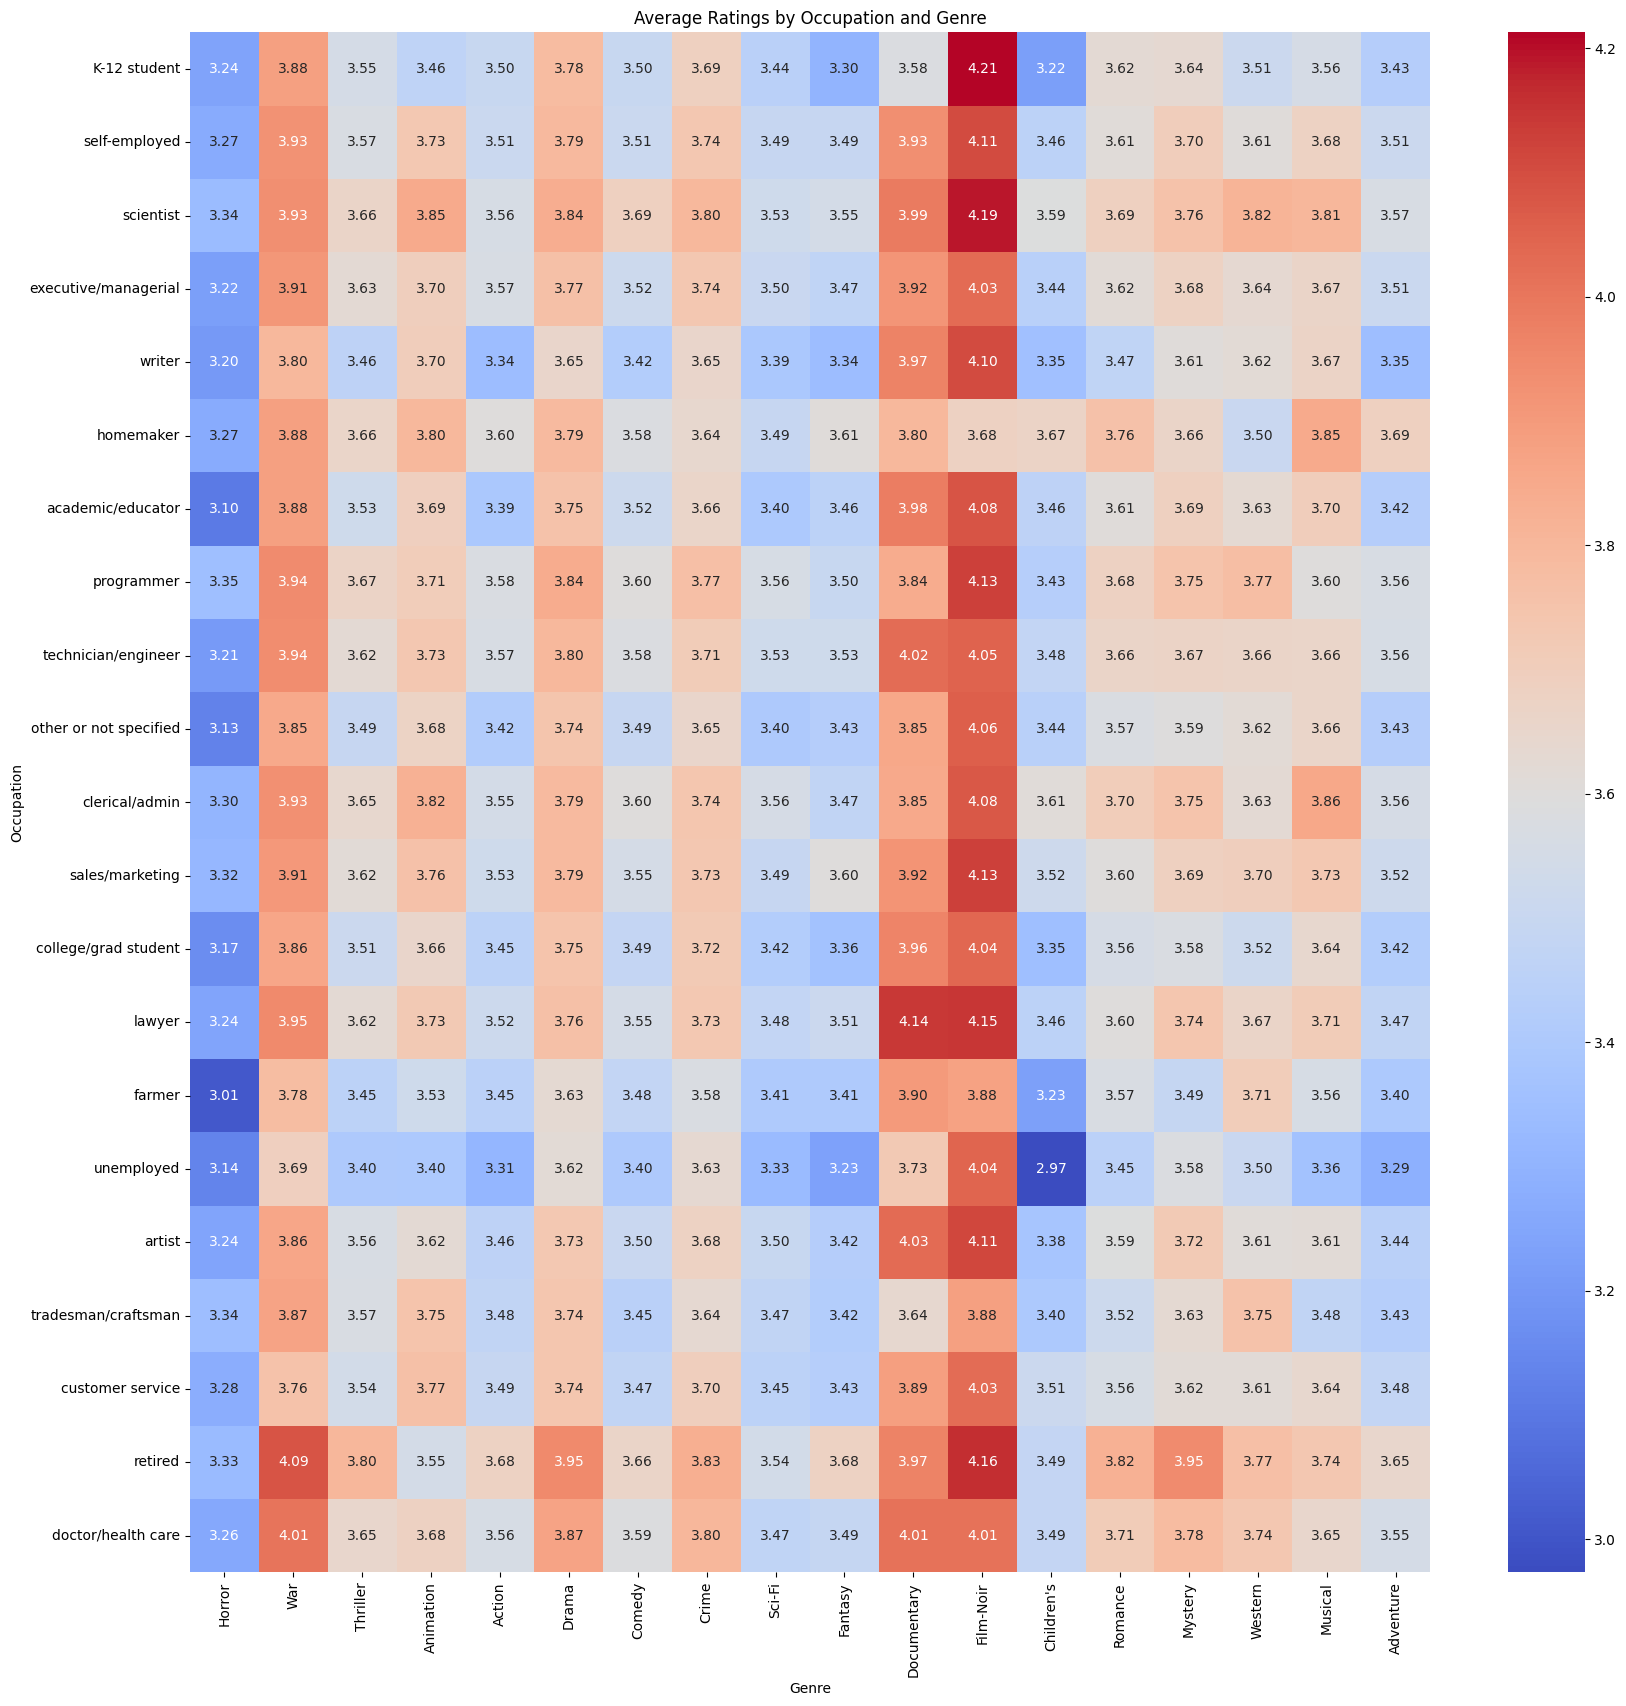

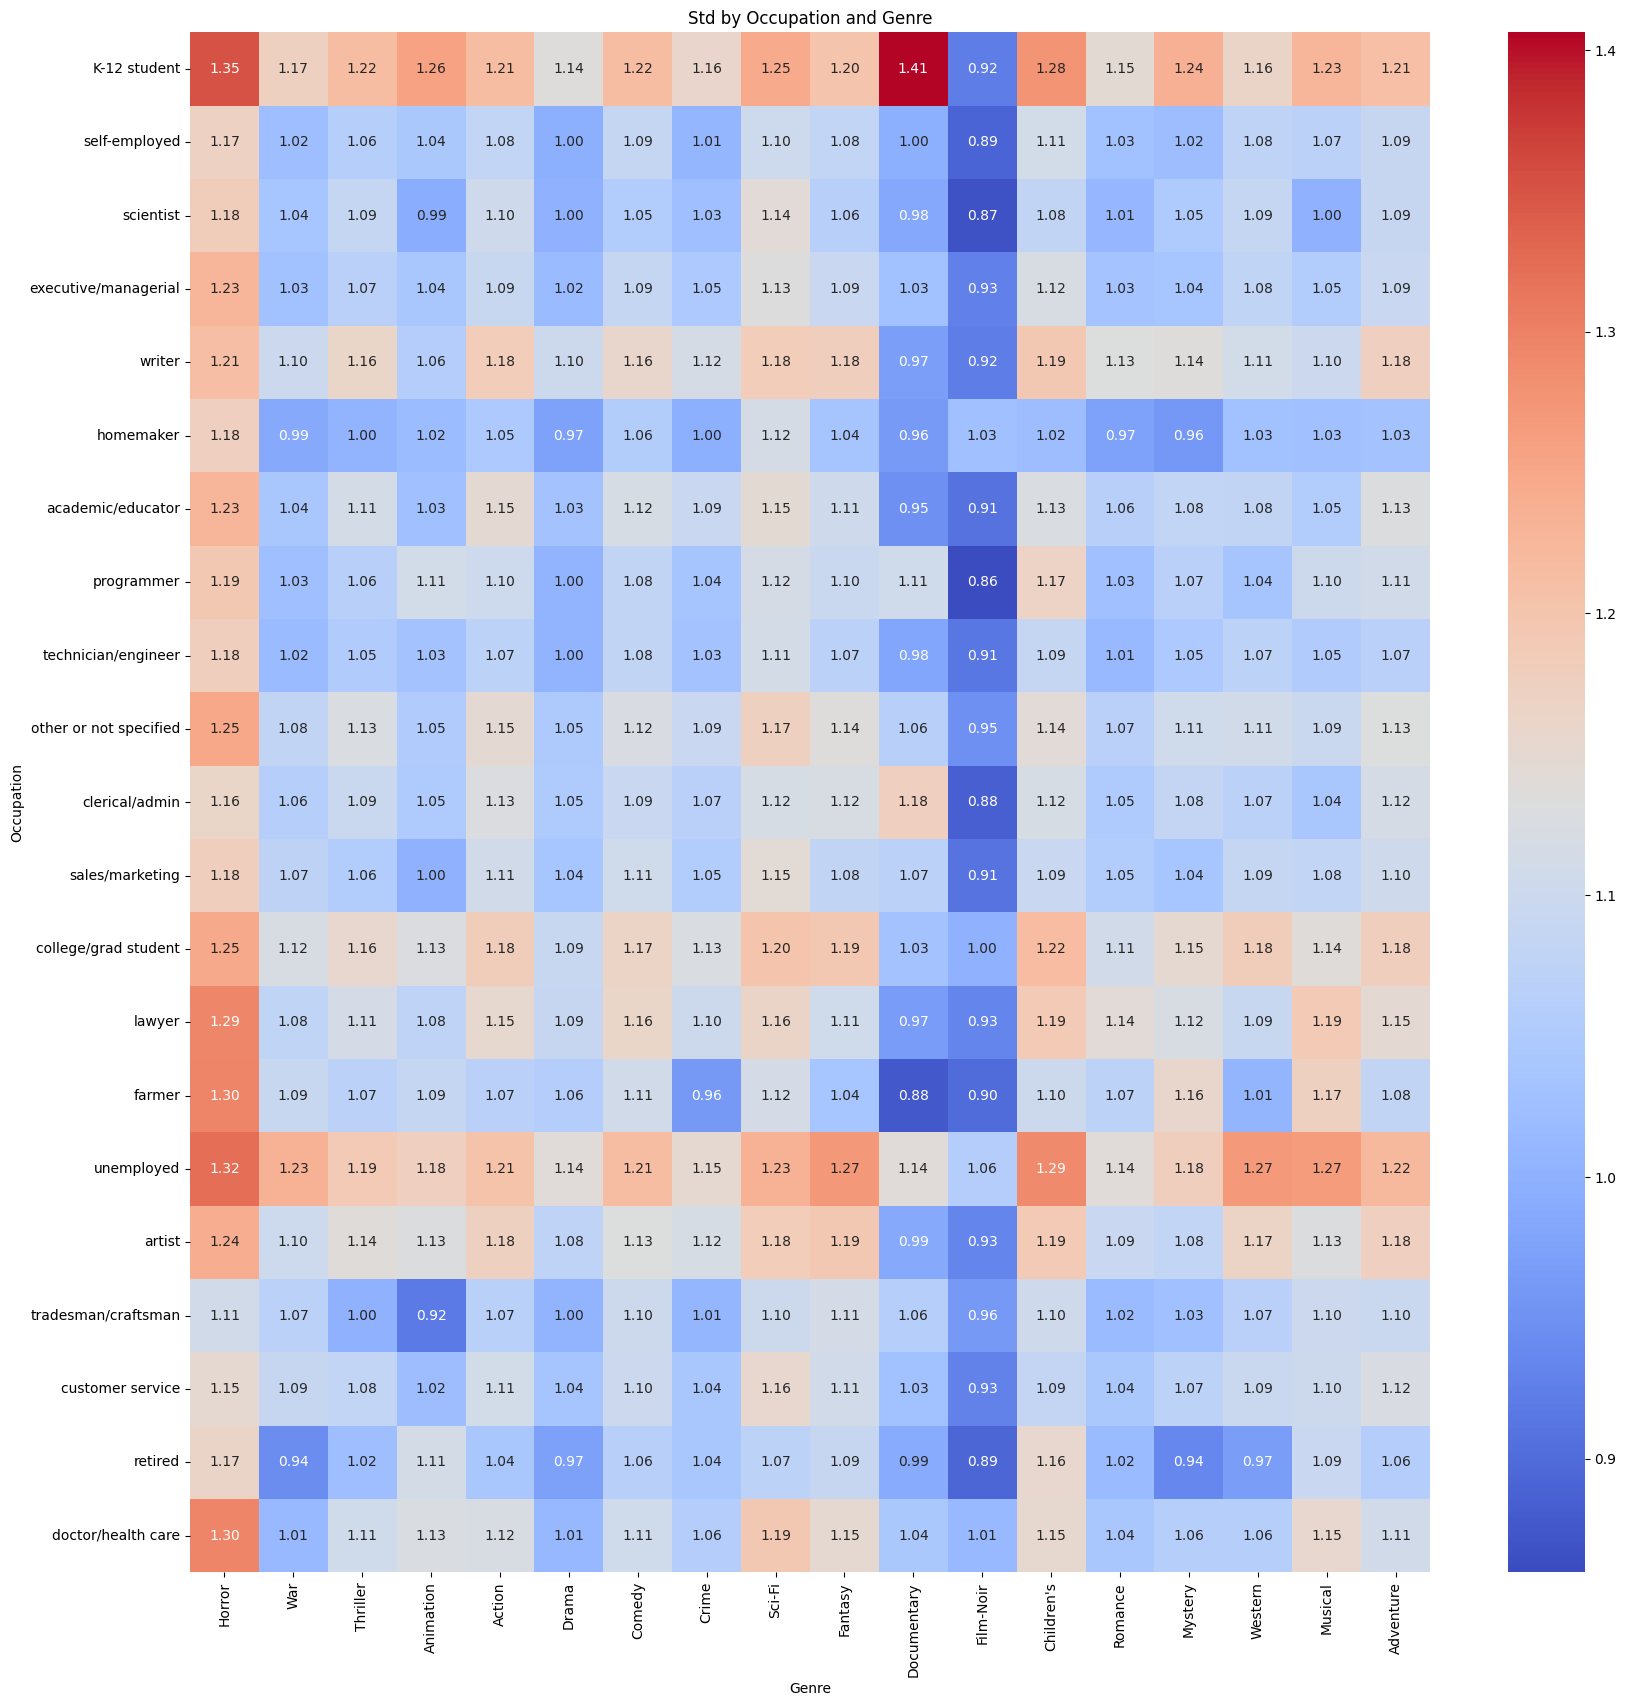

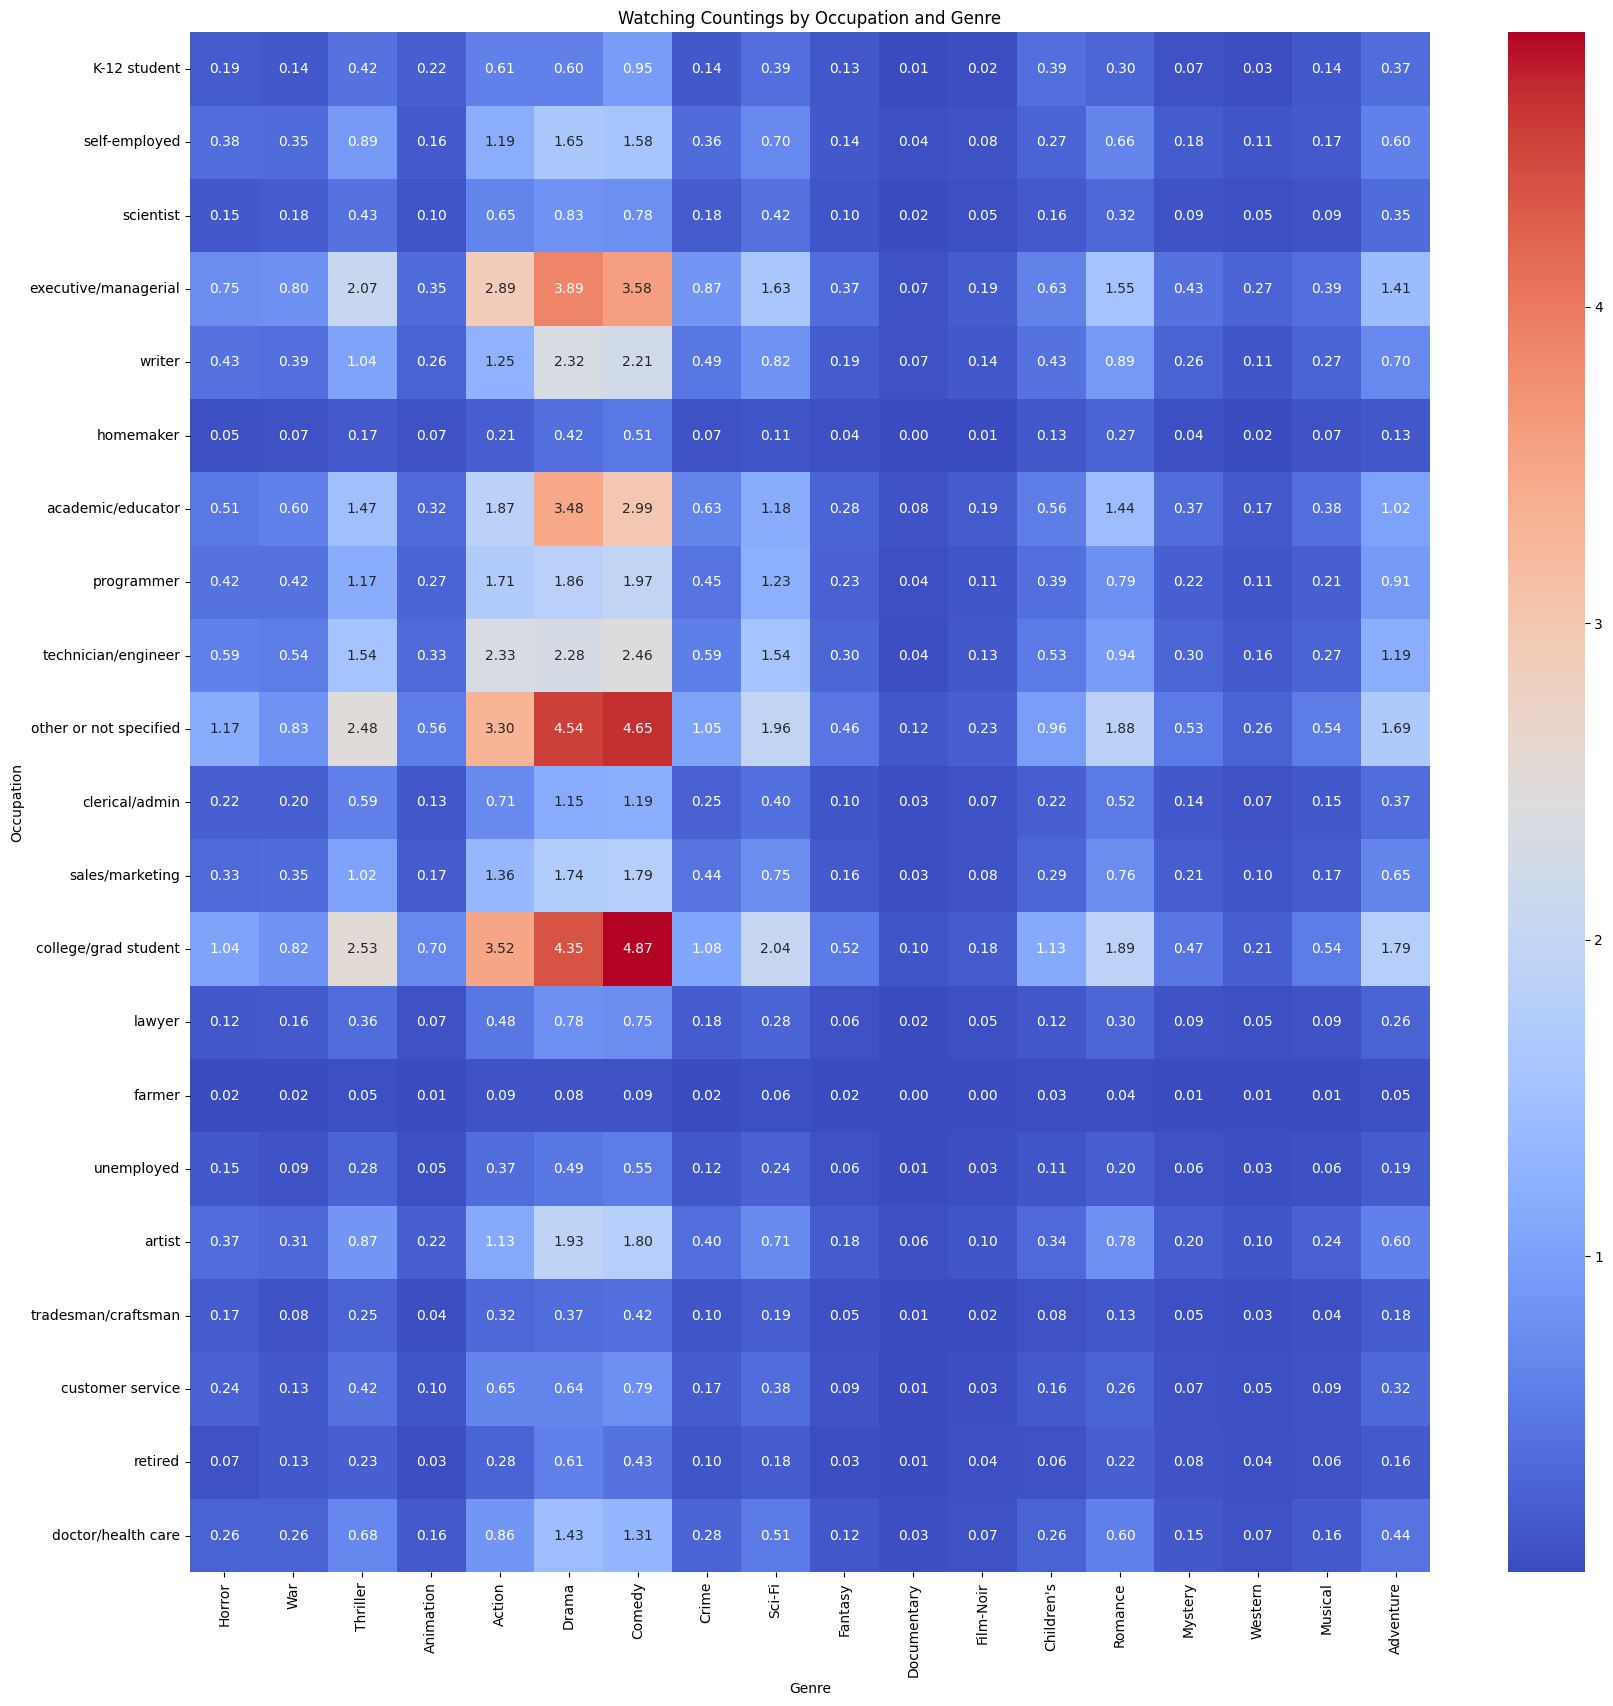

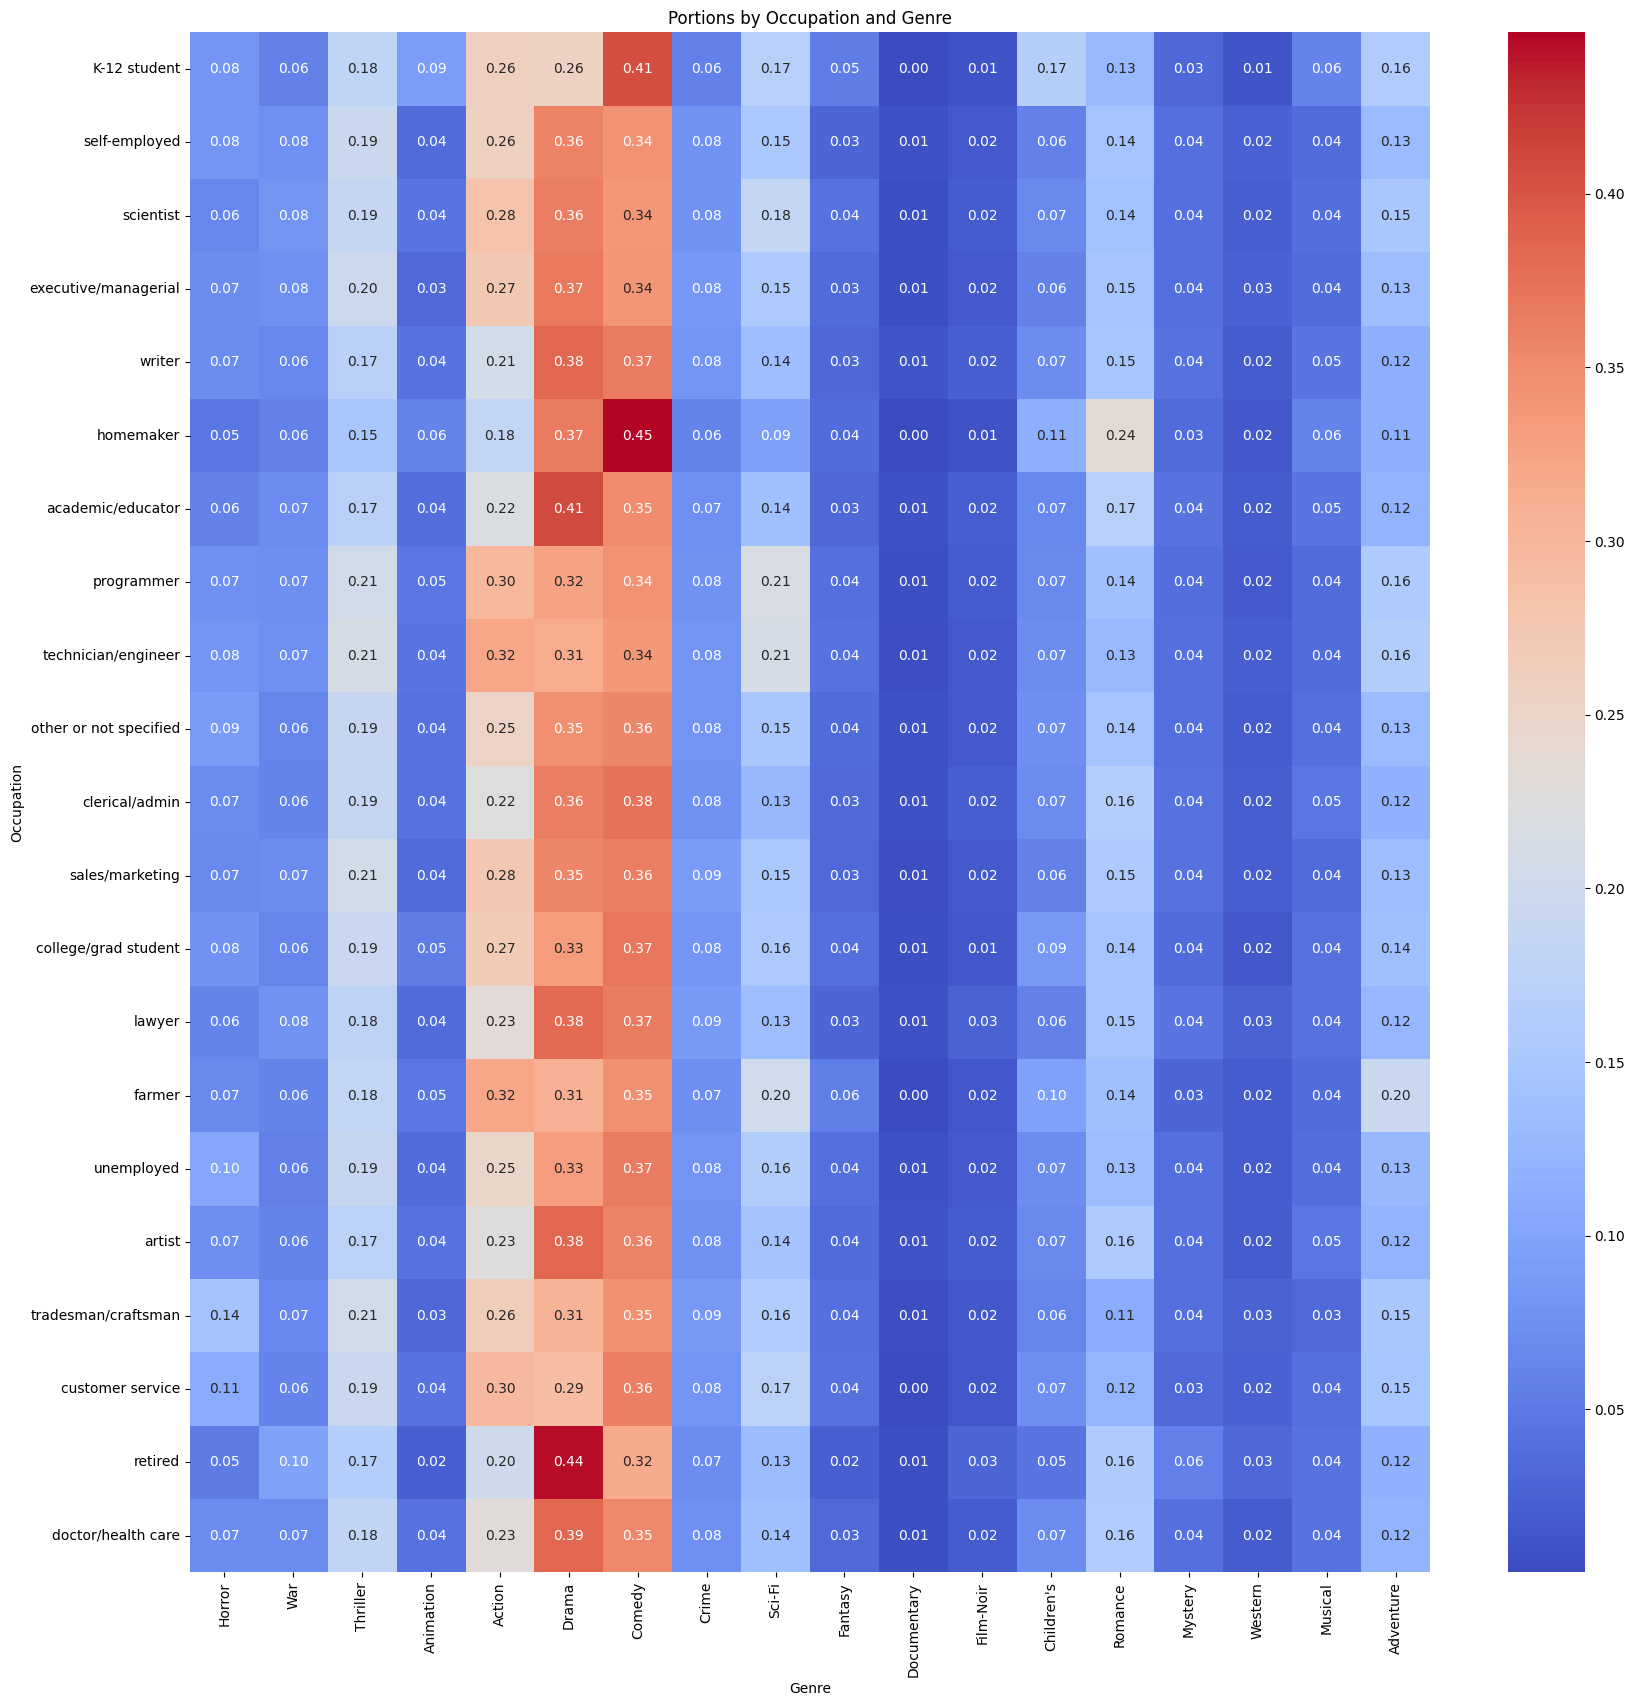

In [20]:
# 用热图的形式呈现数据
import seaborn as sns
import matplotlib.pyplot as plt

# 提取 mean 数据
mean_data = df_2.loc[:, df_2.columns.get_level_values(1) == 'mean'].T

# 使用 seaborn 绘制热图
plt.figure(figsize=(20, 20))
ax = sns.heatmap(mean_data, annot=True, fmt=".2f", cmap='coolwarm')
ax.set_yticklabels(occupations)
plt.title('Average Ratings by Occupation and Genre')
plt.xlabel('Genre')
plt.ylabel('Occupation')
plt.savefig('./figures/0_1_ratings')

# 提取 std 数据
std_data = df_2.loc[:, df_2.columns.get_level_values(1) == 'std'].T

# 使用 seaborn 绘制热图
plt.figure(figsize=(20, 20))
ax = sns.heatmap(std_data, annot=True, fmt=".2f", cmap='coolwarm')
ax.set_yticklabels(occupations)
plt.title('Std by Occupation and Genre')
plt.xlabel('Genre')
plt.ylabel('Occupation')
plt.savefig('./figures/0_2_stds')

# 提取 count 数据
count_data = df_2.loc[:, df_2.columns.get_level_values(1) == 'count'].T

# 使用 seaborn 绘制热图
plt.figure(figsize=(20, 20))
ax = sns.heatmap(count_data / 10000, annot=True, fmt=".2f", cmap='coolwarm')
ax.set_yticklabels(occupations)
plt.title('Watching Countings by Occupation and Genre')
plt.xlabel('Genre')
plt.ylabel('Occupation')
plt.savefig('./figures/0_3_counts')

# 提取 portion 数据
portion_data = df_2.loc[:, df_2.columns.get_level_values(1) == 'portion'].T

# 使用 seaborn 绘制热图
plt.figure(figsize=(20, 20))
ax = sns.heatmap(portion_data, annot=True, fmt=".2f", cmap='coolwarm')
ax.set_yticklabels(occupations)
plt.title('Portions by Occupation and Genre')
plt.xlabel('Genre')
plt.ylabel('Occupation')
plt.savefig('./figures/0_4_portions')


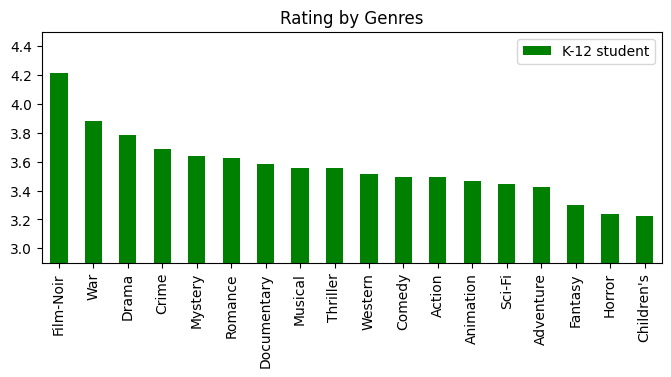

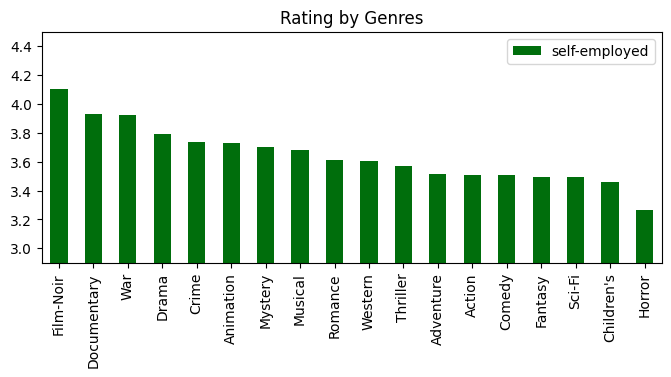

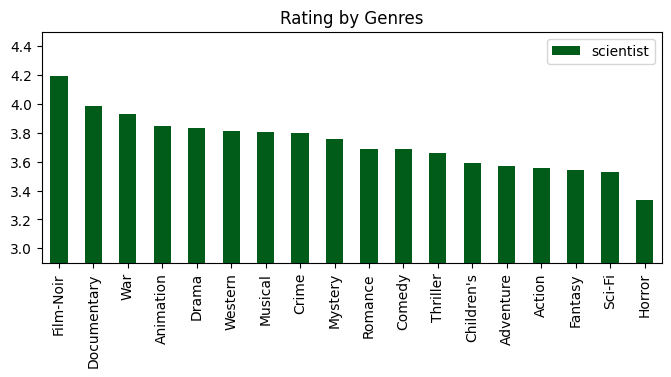

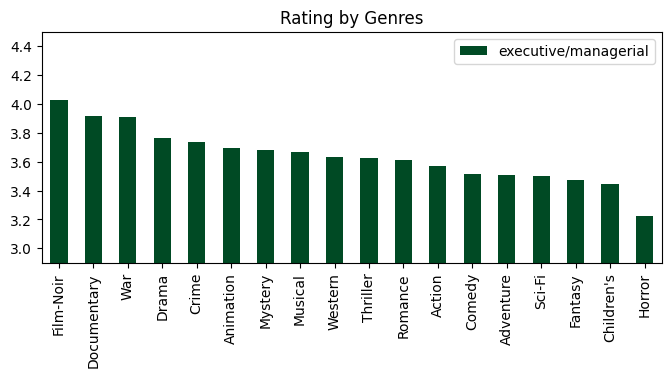

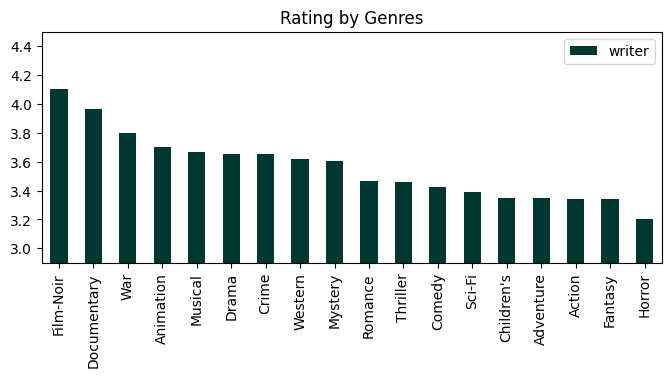

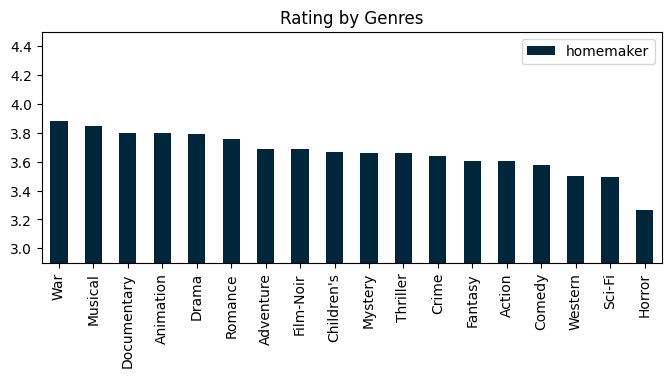

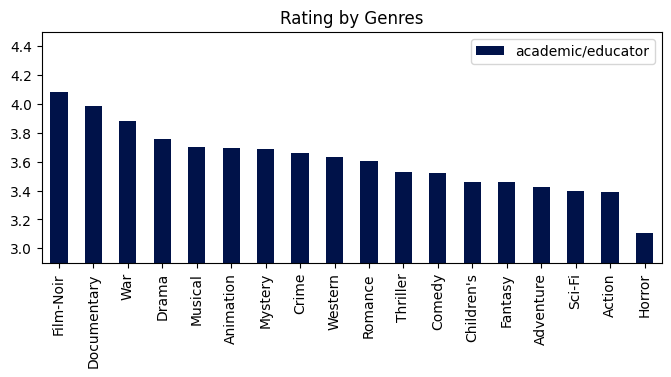

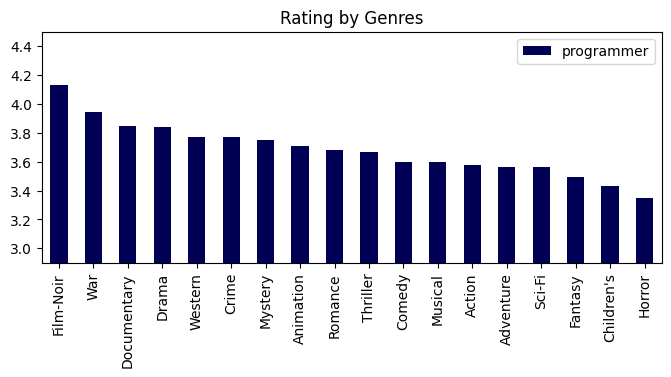

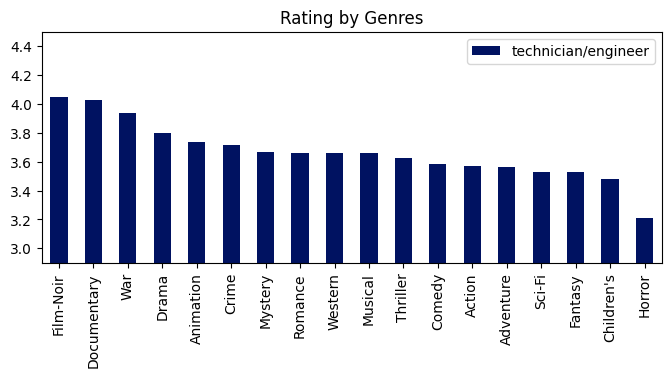

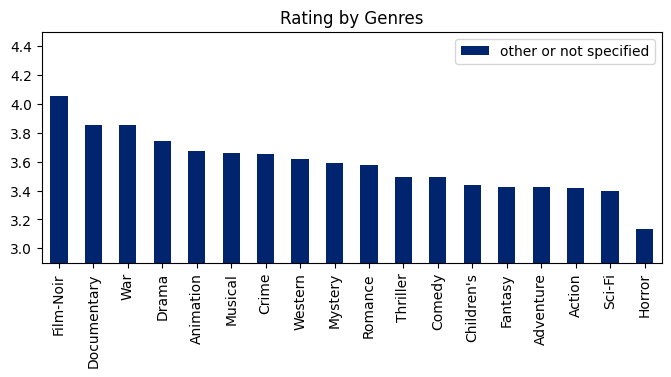

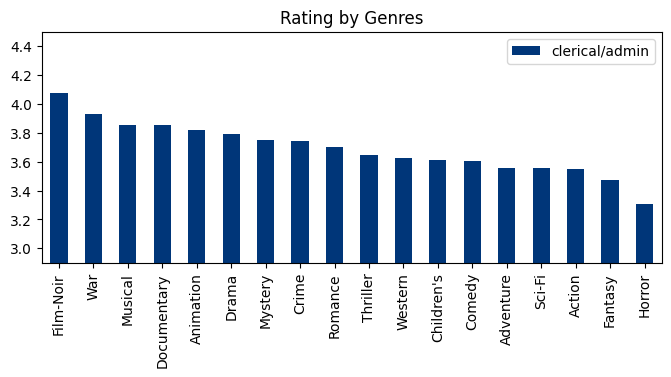

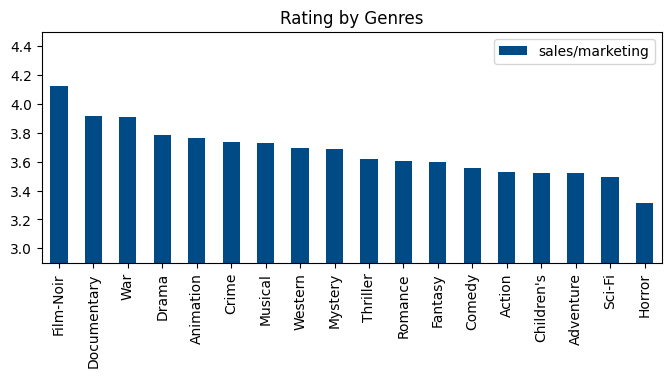

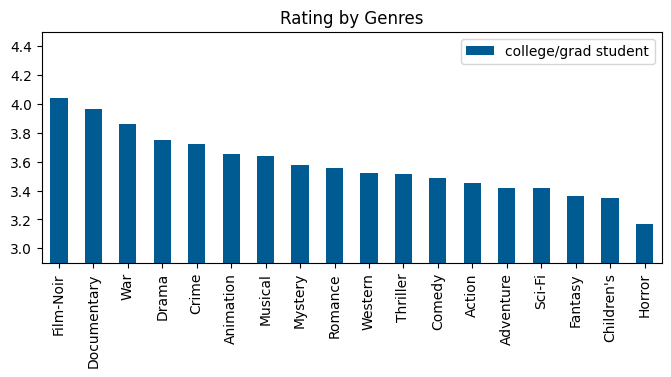

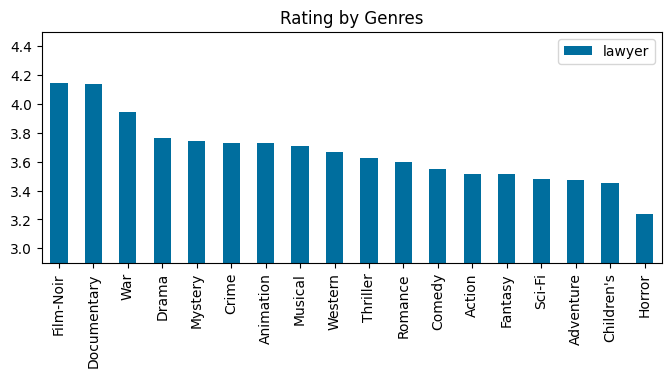

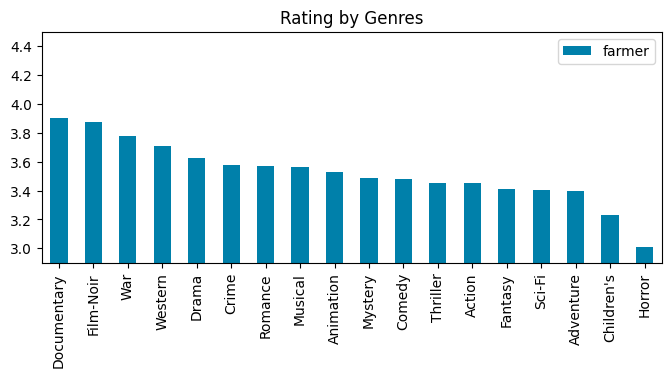

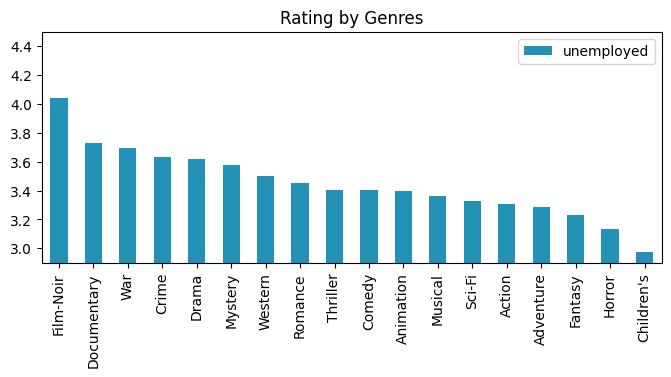

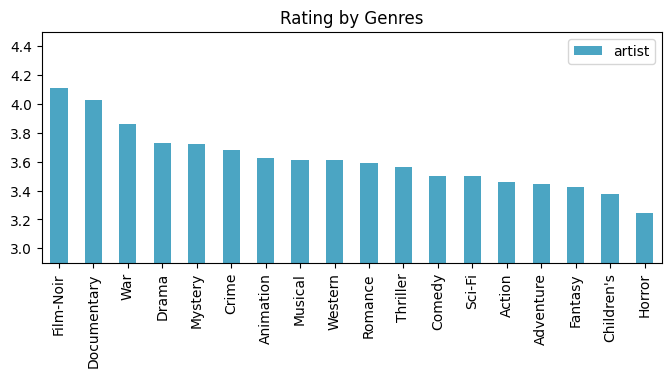

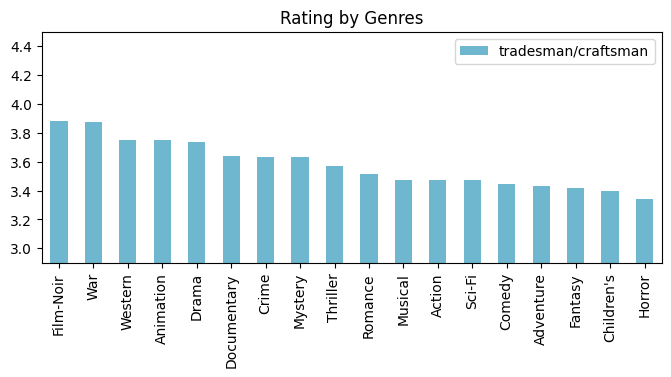

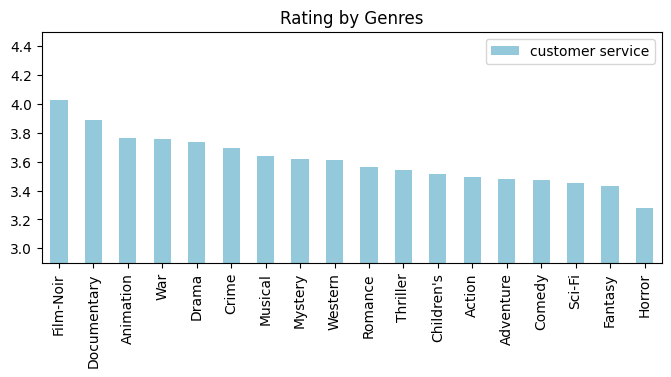

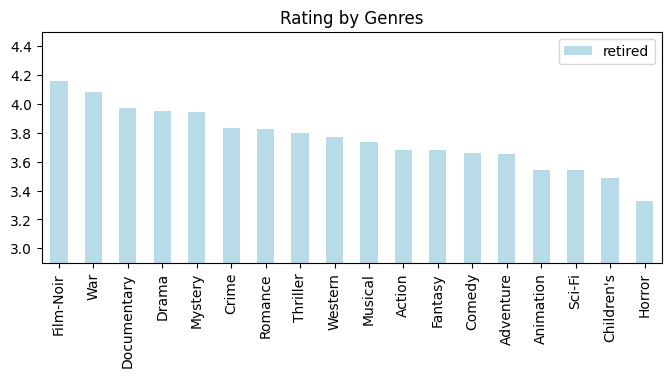

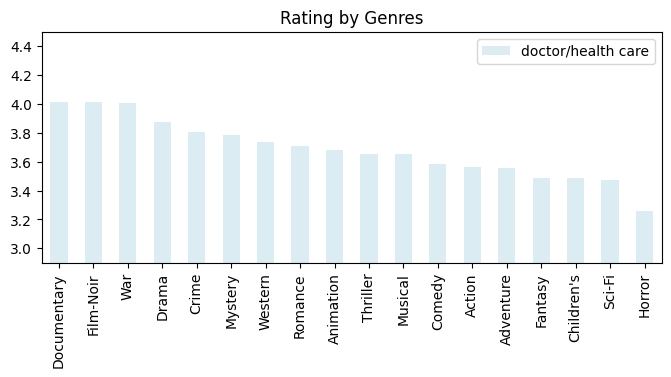

In [21]:
# 将每种职业对每类电影的平均评分从大到小排序后展示
cmap = plt.get_cmap('ocean')
colors = [cmap(i/21) for i in range(len(occupations))]
cnt = 1
for occupation, color in zip(occupations, colors):
    tmp = df_2.sort_values(by=(occupation, 'mean'), inplace=False, ascending=False)
    tmp.plot.bar(y=(occupation, 'mean'),figsize=(8, 3),color=color)
    plt.title('Rating by Genres')
    plt.legend([occupation])
    plt.ylim(2.9, 4.5)
    savefig_title = f"./figures/1_{cnt}_ratings by genres.png"
    plt.savefig(savefig_title)
    cnt += 1

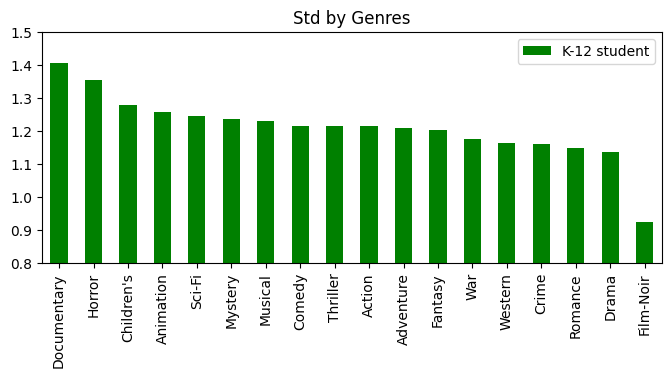

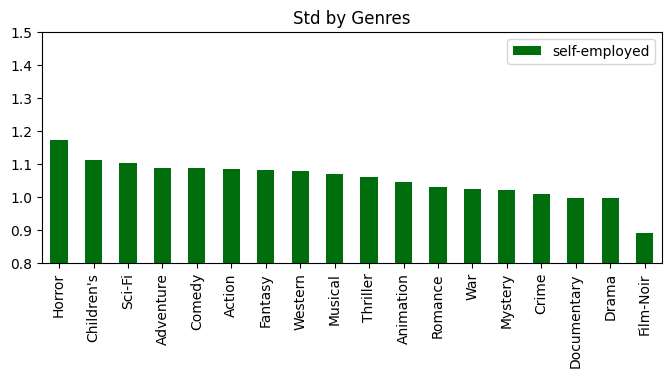

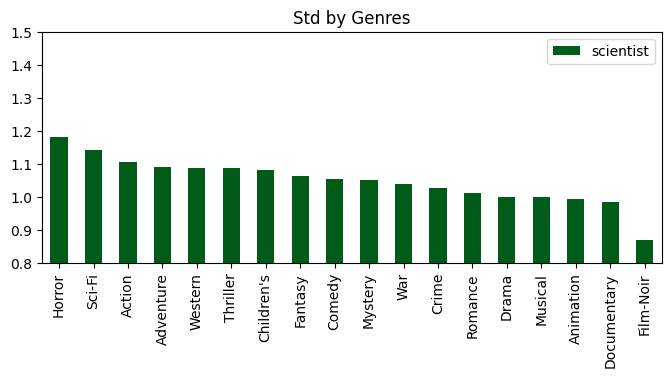

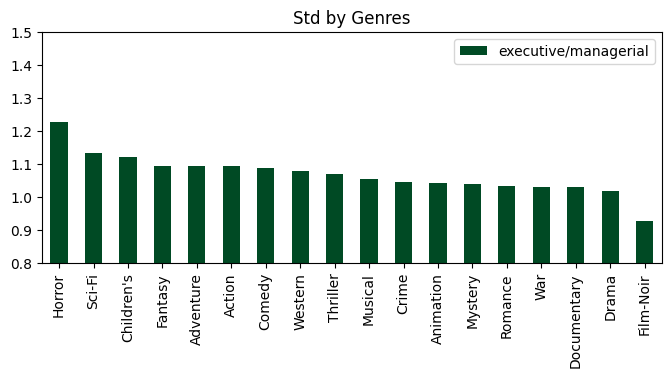

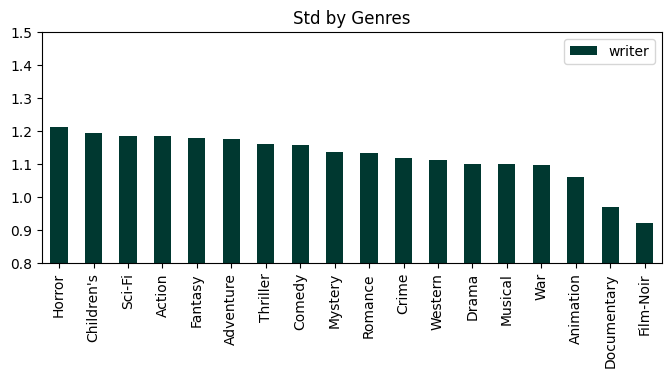

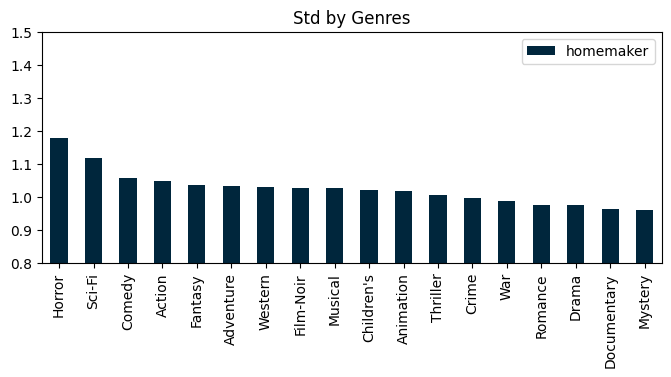

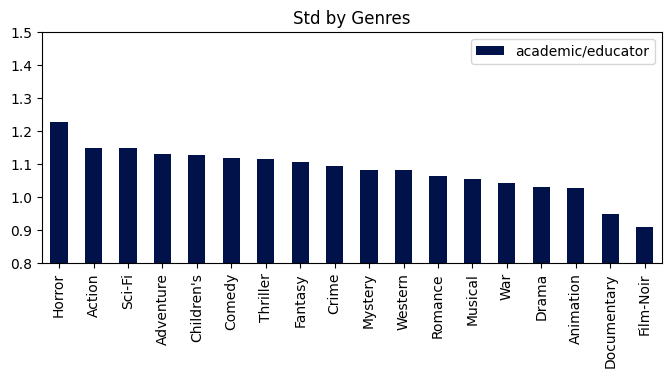

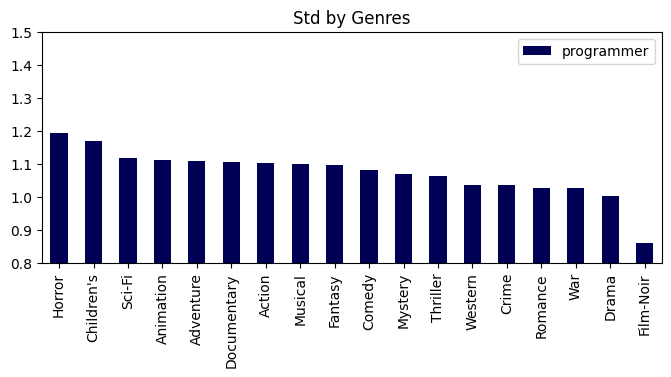

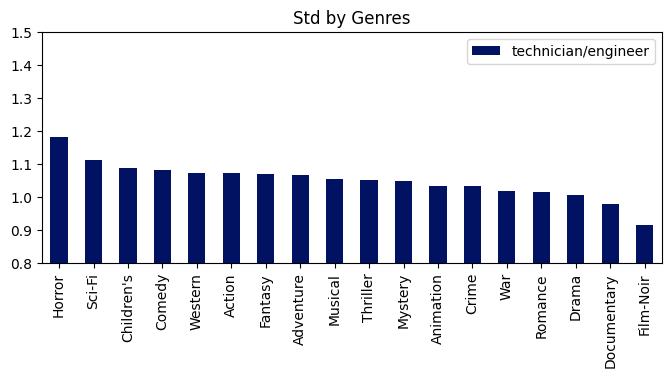

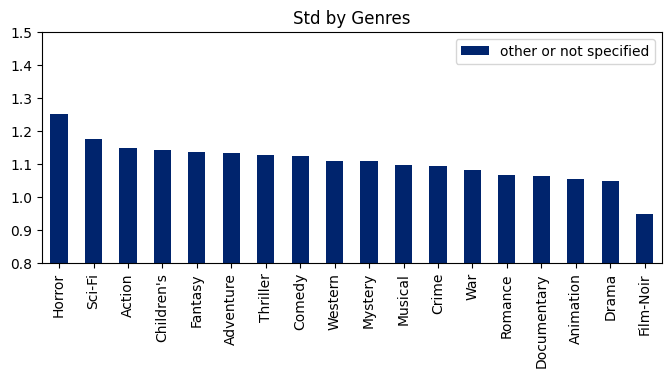

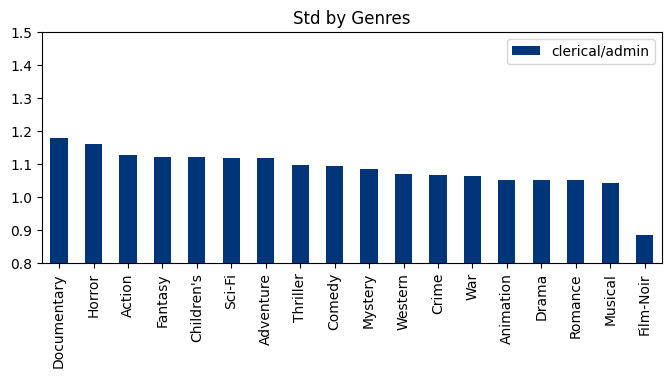

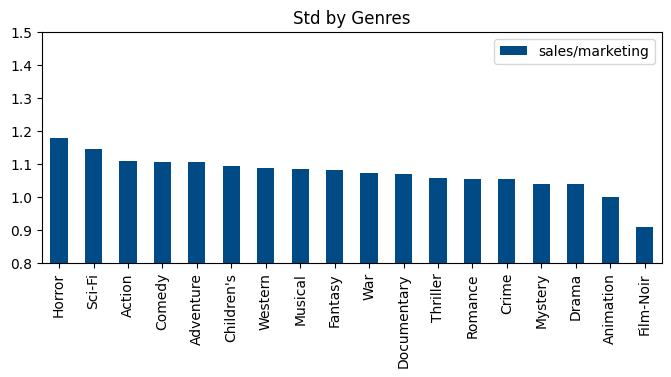

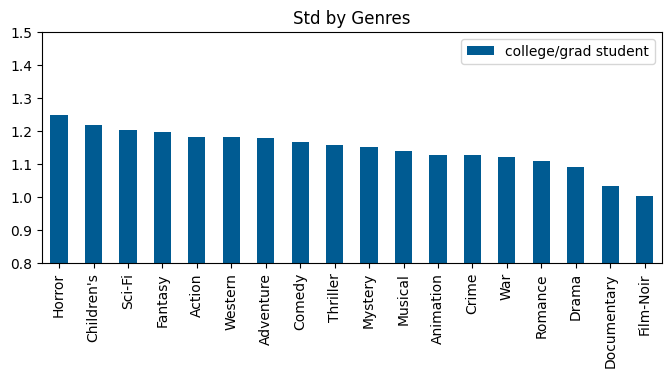

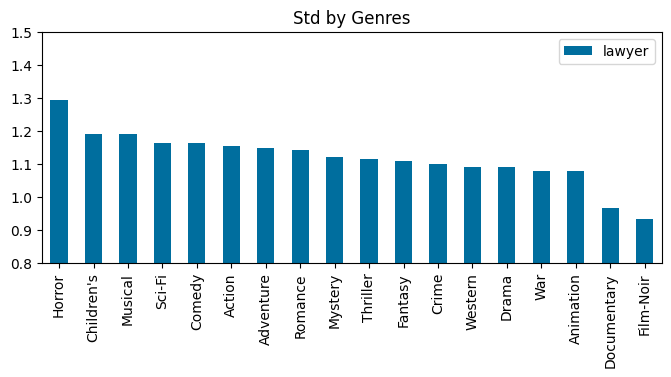

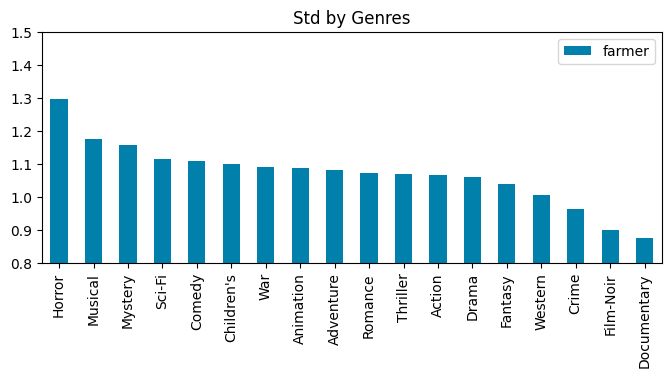

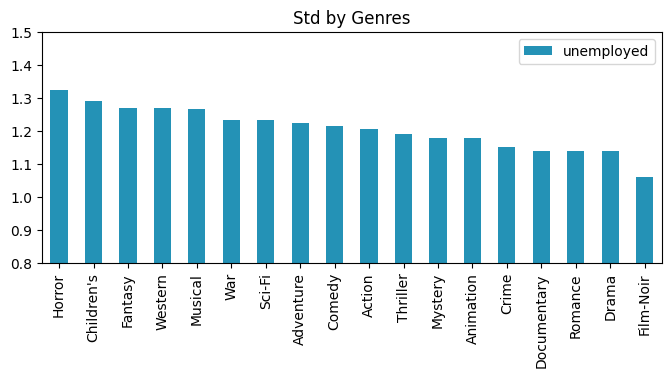

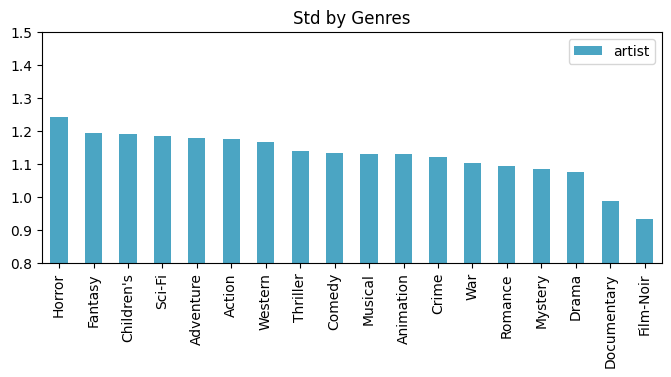

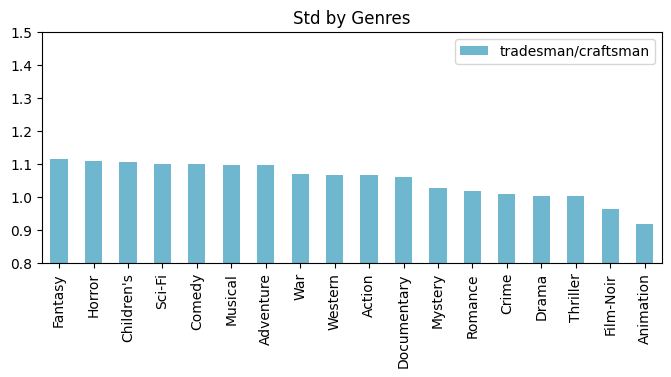

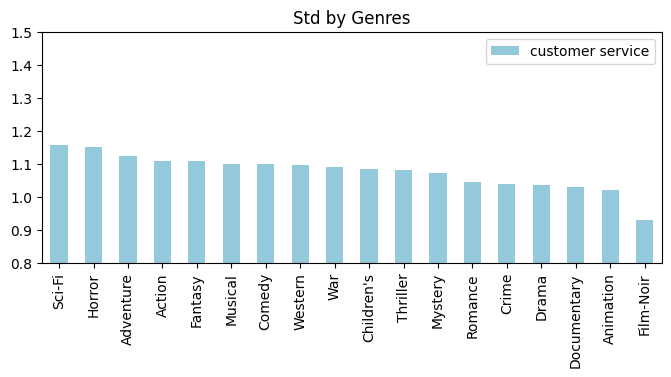

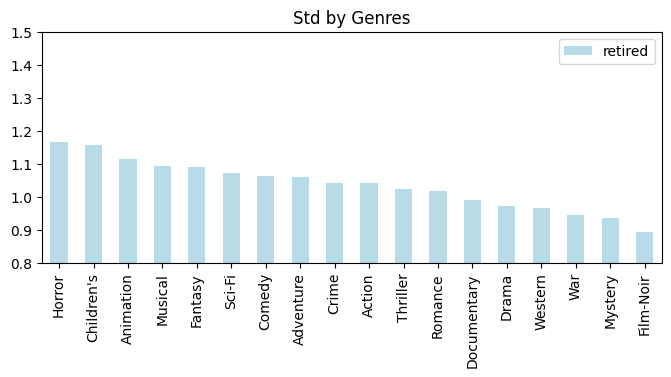

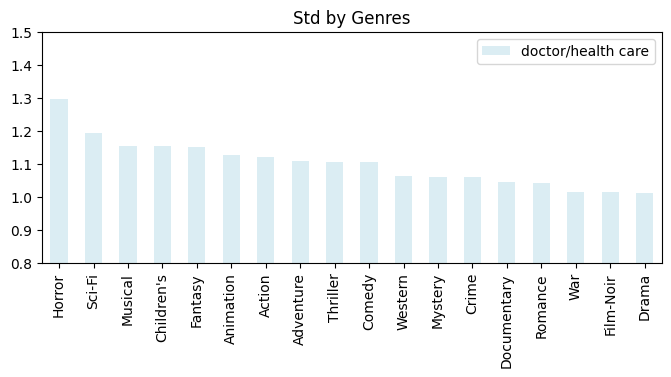

In [22]:
# 将每种职业对每类电影评分的标准差从大到小排序后展示
cnt = 1
for (occupation, color) in zip(occupations, colors):
    tmp = df_2.sort_values(by=(occupation, 'std'), inplace=False, ascending=False)
    tmp.plot.bar(y=(occupation, 'std'), color=color, figsize=(8, 3))
    plt.legend([occupation])
    plt.ylim([0.8, 1.5])
    plt.title('Std by Genres')
    plt.savefig(f'./figures/2_{cnt}_stds by genres.png')
    cnt += 1

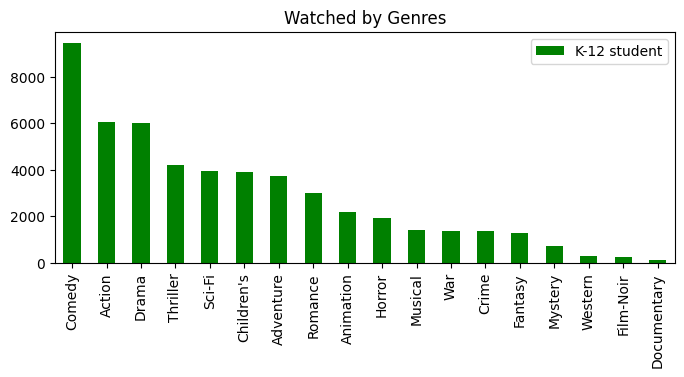

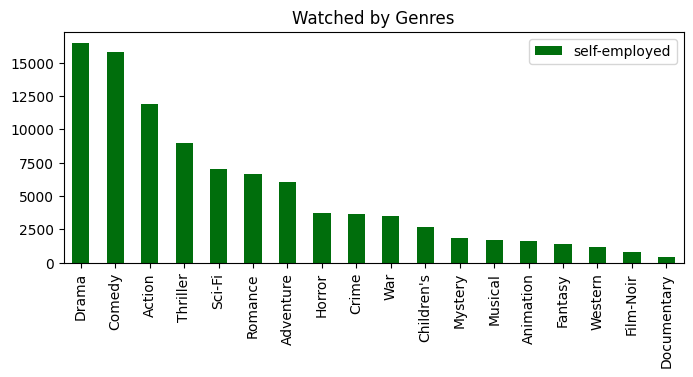

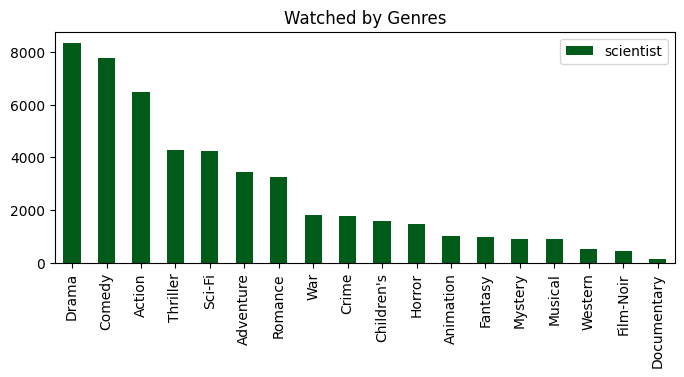

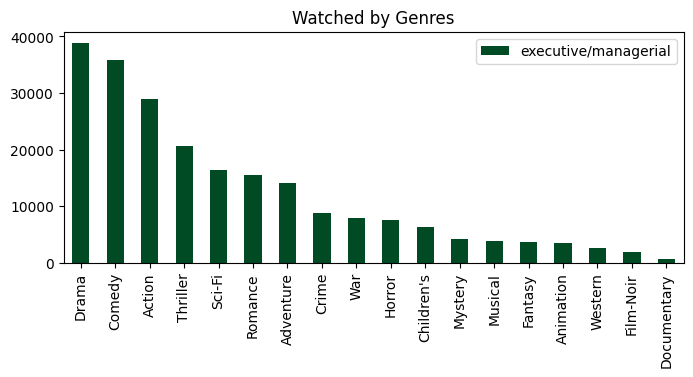

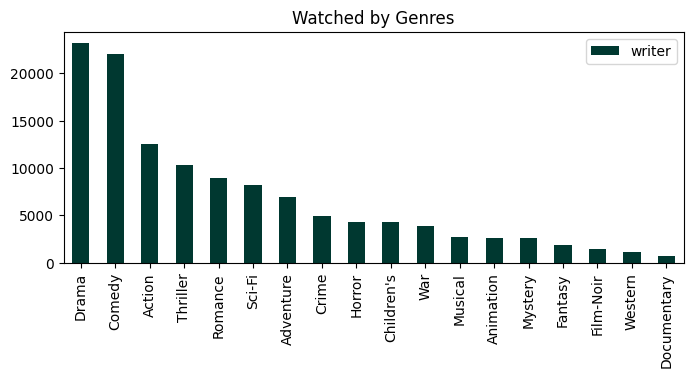

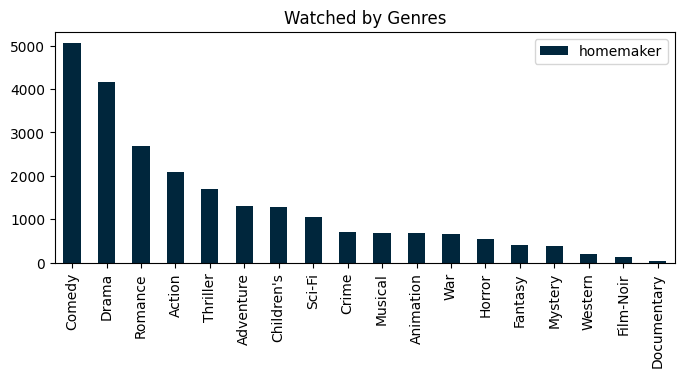

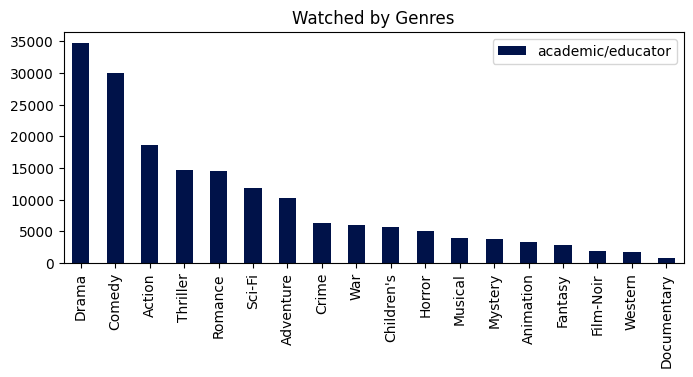

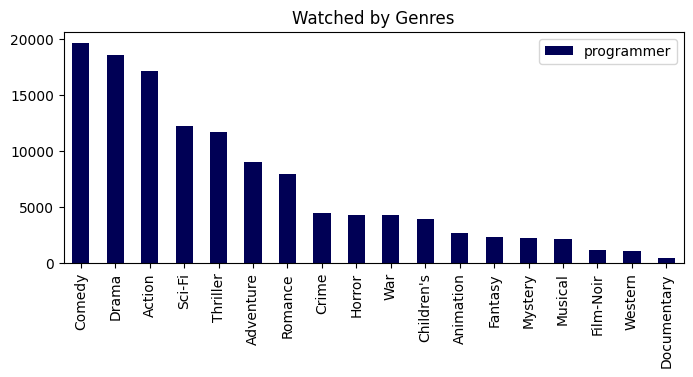

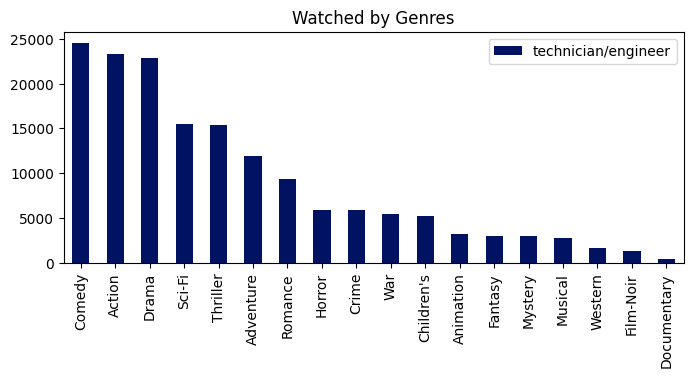

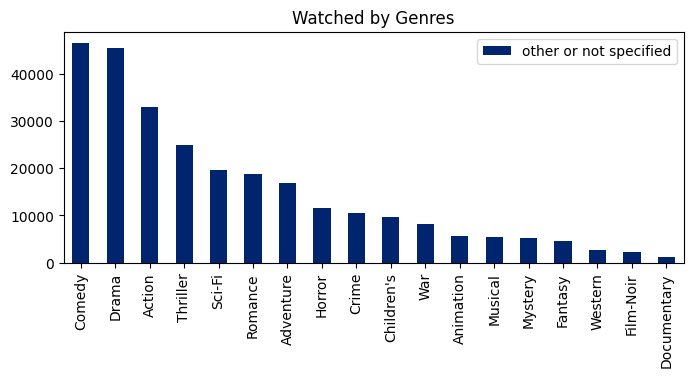

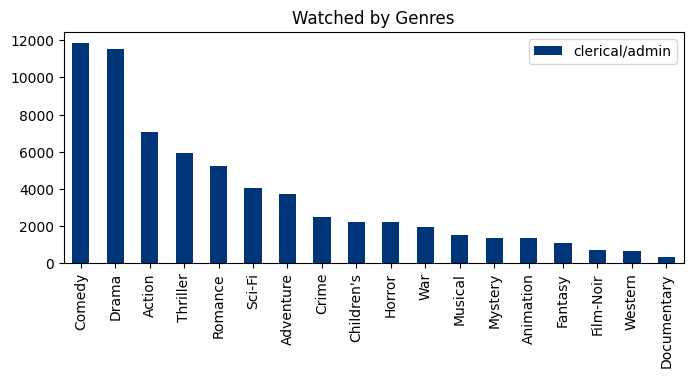

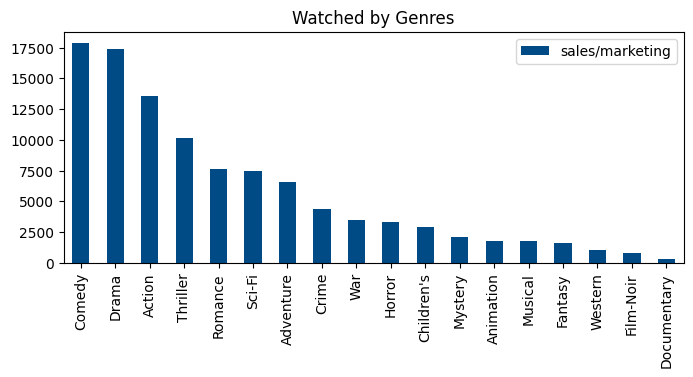

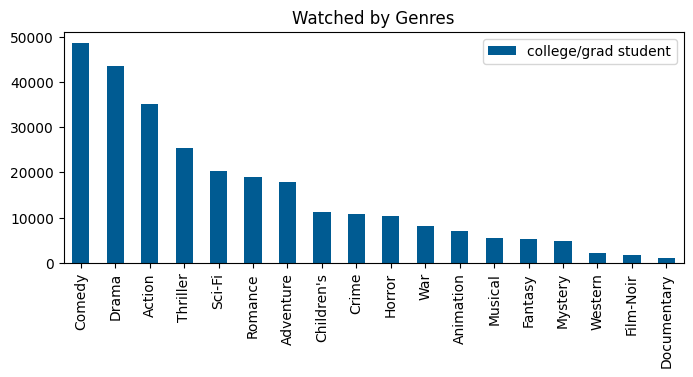

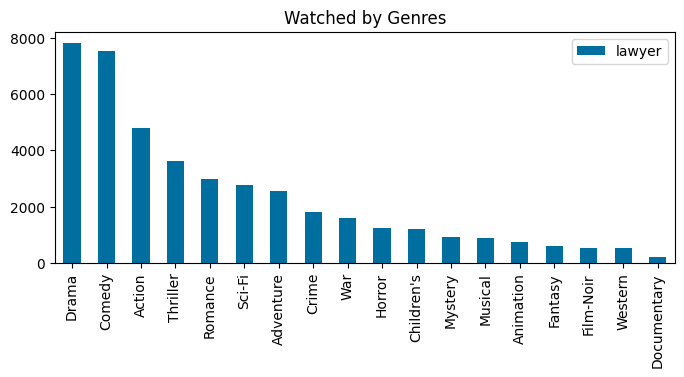

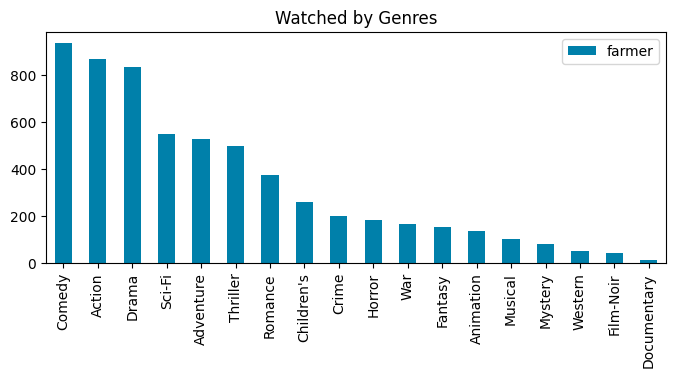

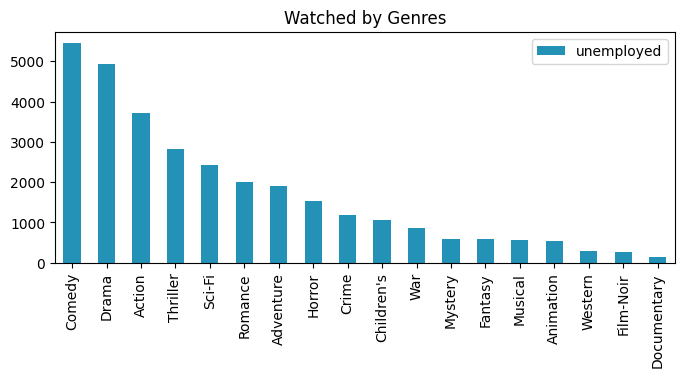

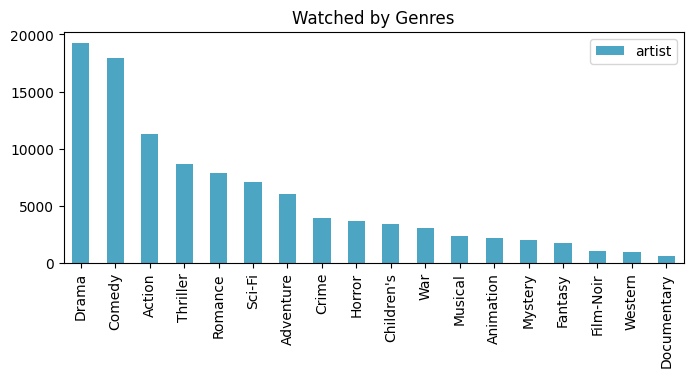

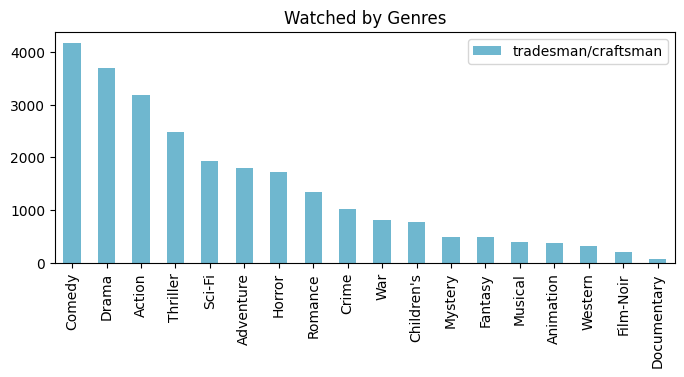

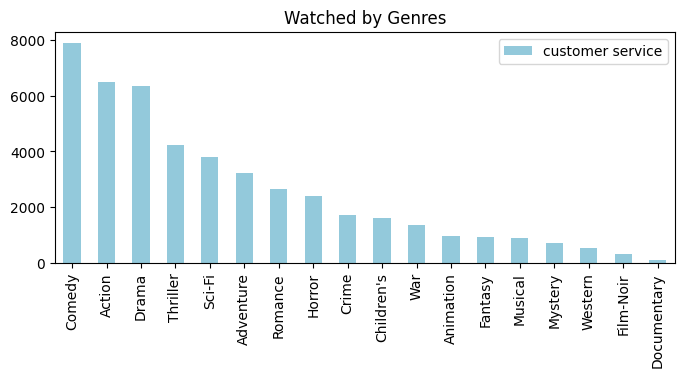

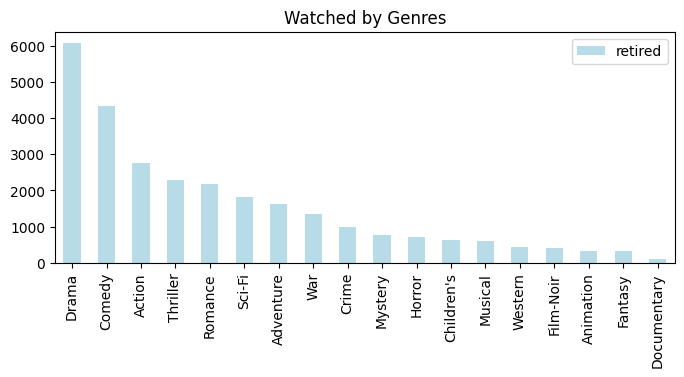

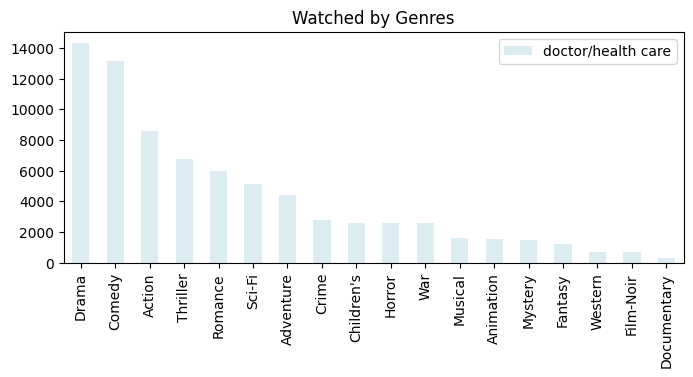

In [23]:
# 将每种职业对每类电影的观看人次（评分数量）从大到小排序后展示
cnt = 1
for (occupation, color) in zip(occupations, colors):
    tmp = df_2.sort_values(by=(occupation, 'count'), inplace=False, ascending=False)
    tmp.plot.bar(y=(occupation, 'count'), color=color, figsize=(8, 3))
    plt.legend([occupation])
    plt.title('Watched by Genres')
    plt.savefig(f'./figures/3_{cnt}_counts by genres.png')
    cnt += 1

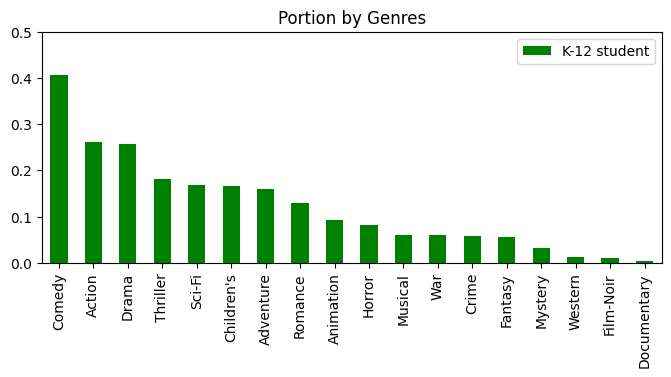

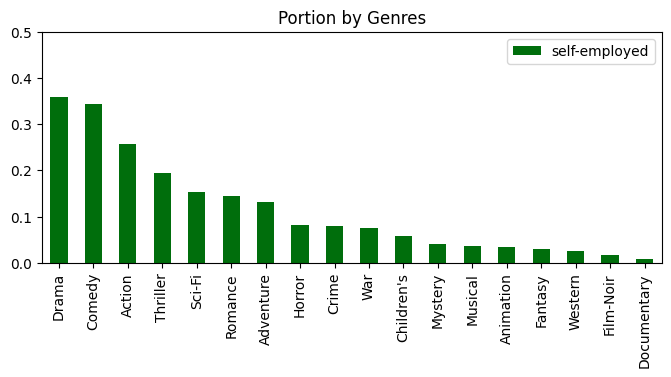

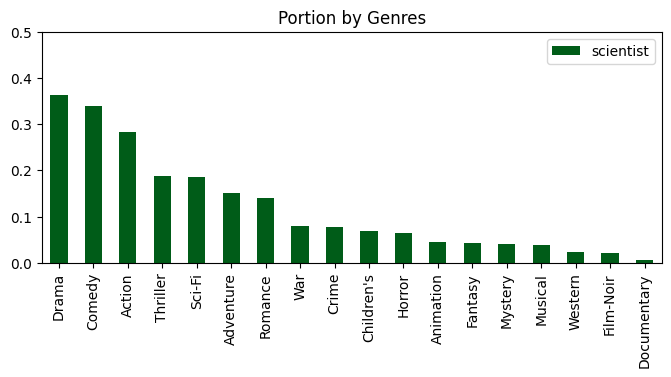

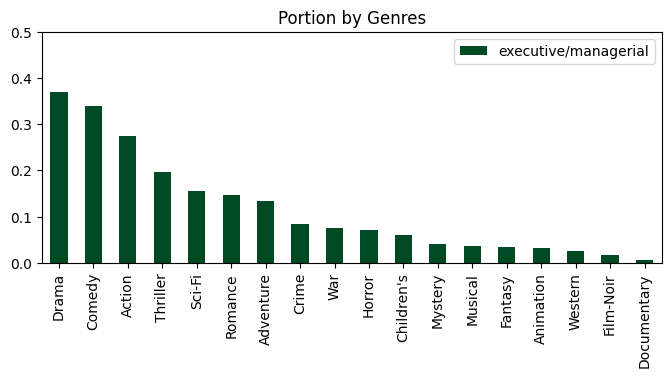

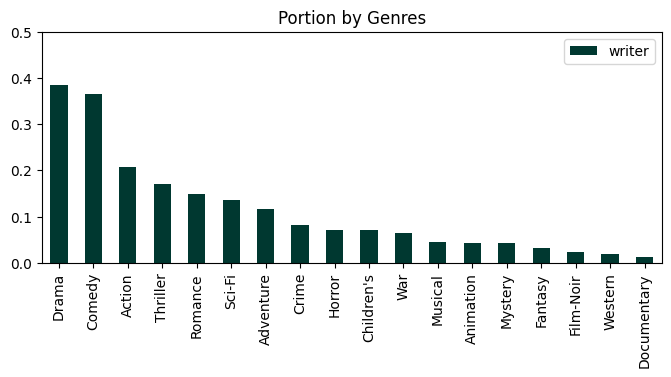

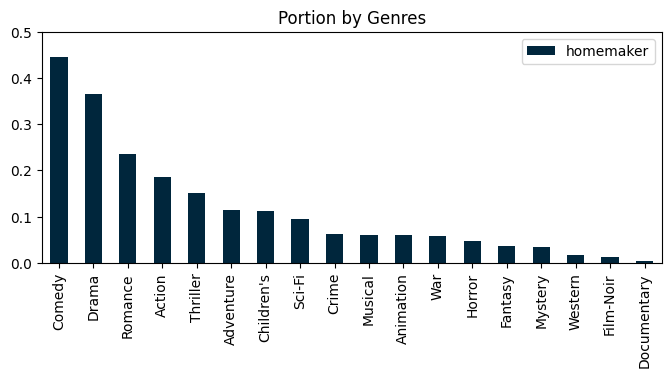

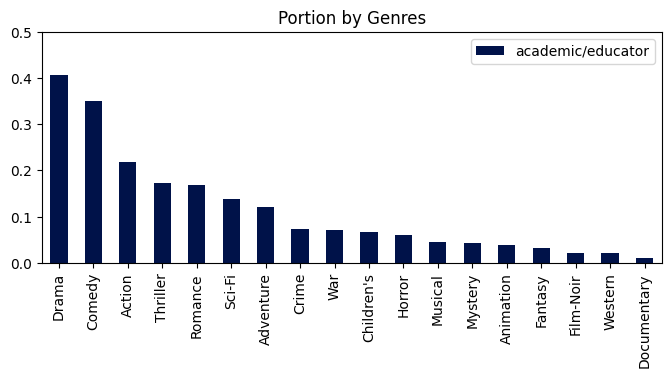

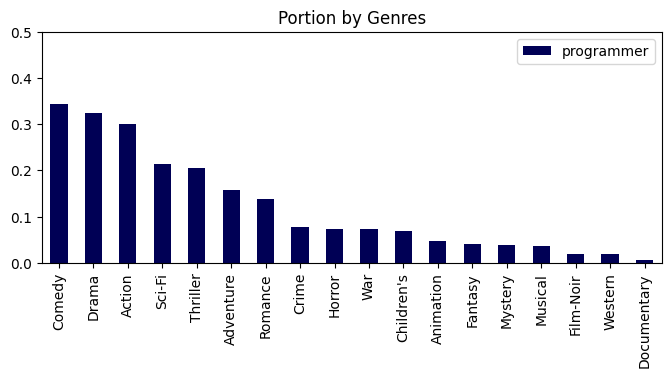

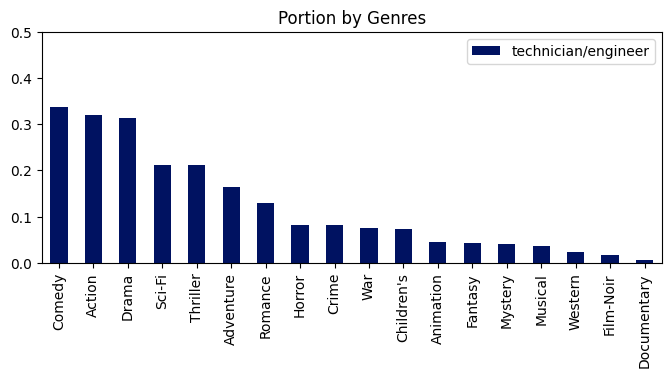

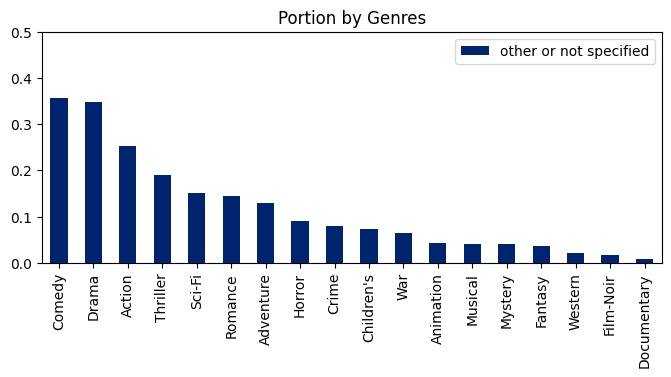

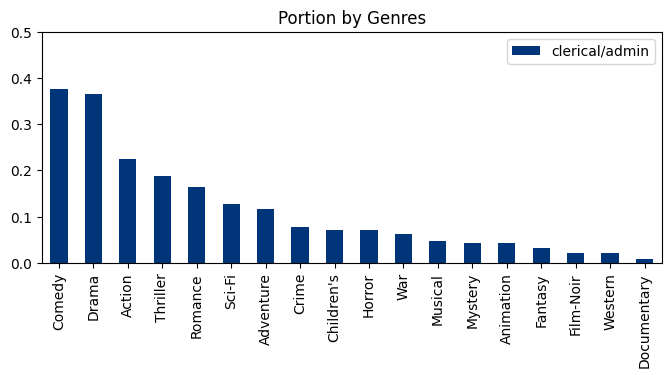

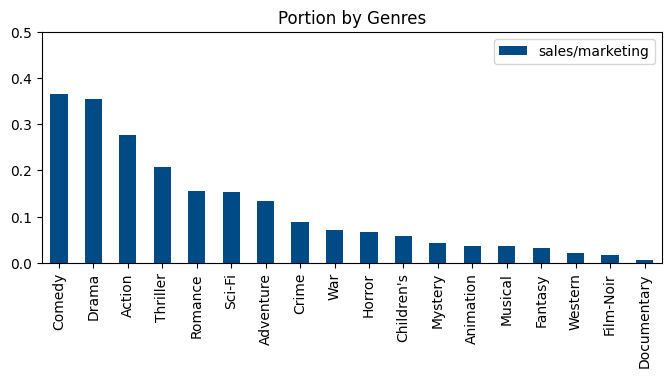

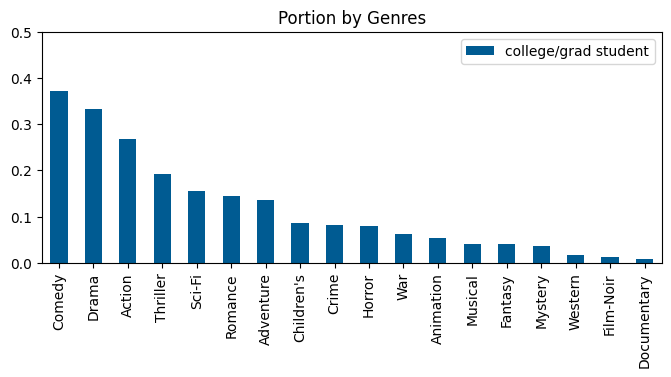

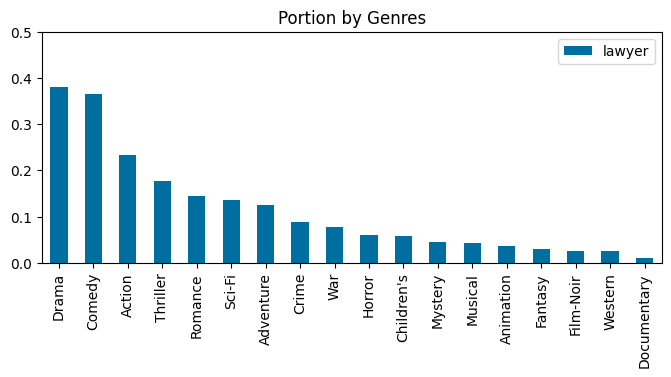

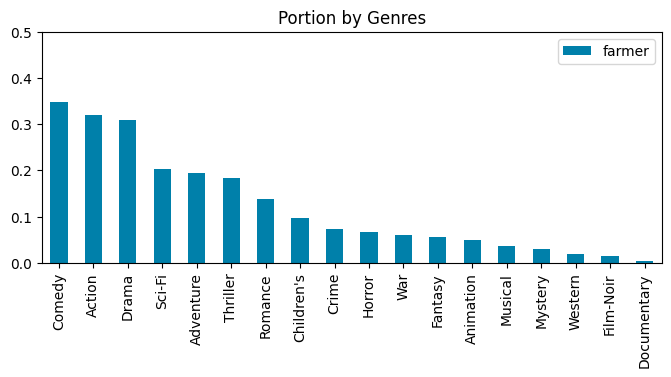

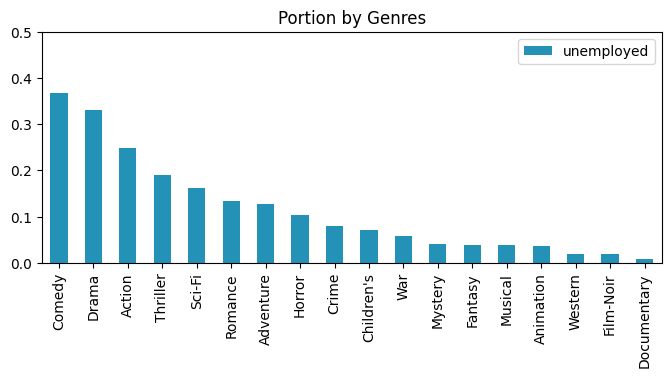

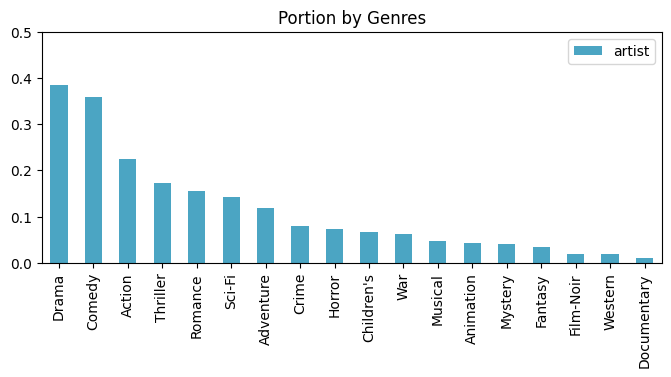

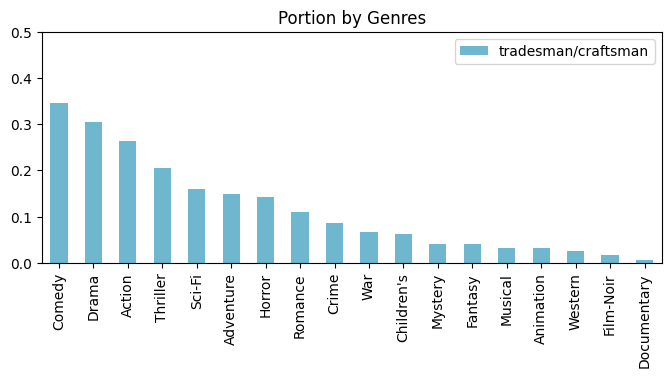

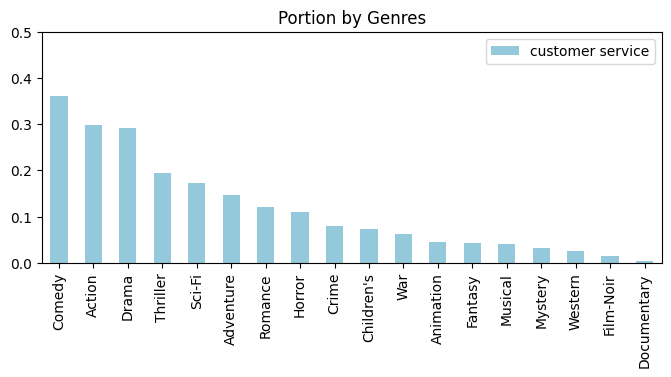

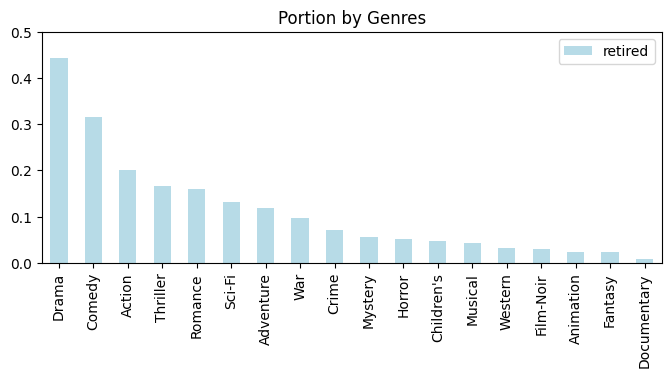

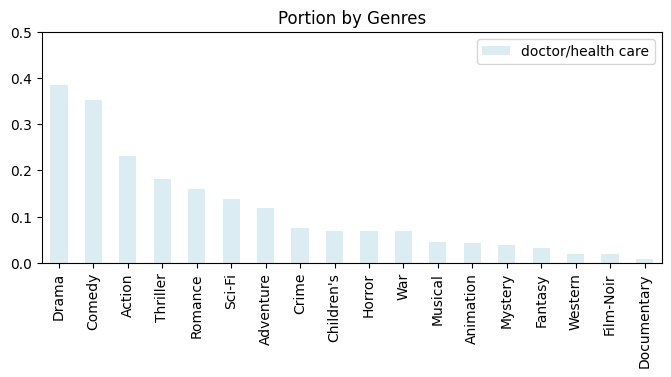

In [24]:
# 将每种职业对每类电影的评分数量在该职业总评分数量中的比例从大到小排序后展示(注意一个电影可以属于多个类，因此总和>1)
cnt = 1
for occupation, color in zip(occupations, colors):
    tmp = df_2.sort_values(by=(occupation, 'portion'), inplace=False, ascending=False)
    tmp.plot.bar(y=(occupation, 'portion'),figsize=(8, 3),color=color)
    plt.title('Portion by Genres')
    plt.legend([occupation])
    plt.ylim(0, 0.5)
    savefig_title = f"./figures/4_{cnt}_portions by genres.png"
    plt.savefig(savefig_title)
    cnt += 1

## 二、用户对电影的打分预测

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from catboost import Pool, CatBoostRegressor
from scipy.sparse import hstack
from scipy.sparse import csr_matrix


In [26]:
# 构建特征向量所需的数据
user_movie = pd.merge(users, ratings, on='user_id', how='inner')
user_movie_info = pd.merge(user_movie, movies_info, on='movie_id', how='inner')
user_movie_info = user_movie_info.set_index('user_id')
print('user_movie_info:')
user_movie_info.head()

user_movie_info:


gender zipcode  age_desc      occ_desc  movie_id  rating  timestamp  \
user_id                                                                       
1            F   48067  Under 18  K-12 student      1193       5  978300760   
1            F   48067  Under 18  K-12 student       661       3  978302109   
1            F   48067  Under 18  K-12 student       914       3  978301968   
1            F   48067  Under 18  K-12 student      3408       4  978300275   
1            F   48067  Under 18  K-12 student      2355       5  978824291   

                                            name                       genre  \
user_id                                                                        
1        One Flew Over the Cuckoo's Nest (1975)                        Drama   
1              James and the Giant Peach (1996)   Animation|Adventure|Family   
1                           My Fair Lady (1964)         Drama|Family|Musical   
1                        Erin Brockovich (2000)              Biography|Drama   
1                           A Bug's Life (1998)   Animation|Adventure|Comedy   

                   release_time  \
user_id                           
1        19 November 1975 (USA)   
1           12 April 1996 (USA)   
1        25 December 1964 (USA)   
1           17 March 2000 (USA)   
1        25 November 1998 (USA)   

                                                     intro  \
user_id                                                      
1        A criminal pleads insanity and is admitted to ...   
1        An orphan, who lives with his two cruel aunts,...   
1        Snobbish phonetics Professor Henry Higgins agr...   
1        An unemployed single mother becomes a legal as...   
1        A misfit ant, looking for "warriors" to save h...   

                            directors  \
user_id                                 
1                        Milos Forman   
1                        Henry Selick   
1                        George Cukor   
1                   Steven Soderbergh   
1        John Lasseter|Andrew Stanton   

                                                stars  
user_id                                                
1         Jack Nicholson|Louise Fletcher|Will Sampson  
1         Paul Terry|Joanna Lumley|Pete Postlethwaite  
1        Audrey Hepburn|Rex Harrison|Stanley Holloway  
1           Julia Roberts|Albert Finney|David Brisbin  
1         Kevin Spacey|Dave Foley|Julia Louis-Dreyfus

In [27]:
# 划分训练集和测试集
train, test = train_test_split(user_movie_info, test_size=0.2, random_state=42)
y_train = train['rating']
y_test = test['rating']
train = train.reset_index()
train.head()

user_id gender zipcode age_desc              occ_desc  movie_id  rating  \
0     2116      M   49546    18-24  college/grad student      3809       3   
1     2458      M   85040    25-34  executive/managerial       608       1   
2      752      F   97401    25-34        clerical/admin      1034       4   
3     3871      M   64468    18-24  college/grad student       231       5   
4     5153      M   60046    25-34  executive/managerial      2470       3   

   timestamp                        name                    genre  \
0  974649905     What About Bob? (1991)                    Comedy   
1  974176907               Fargo (1996)      Crime|Drama|Thriller   
2  976223846             Freeway (1996)        Comedy|Crime|Drama   
3  965844557     Dumb and Dumber (1994)                    Comedy   
4  961968903  'Crocodile' Dundee (1986)   Action|Adventure|Comedy   

                release_time  \
0          17 May 1991 (USA)   
1         5 April 1996 (USA)   
2  3 September 1997 (France)   
3     16 December 1994 (USA)   
4  24 April 1986 (Australia)   

                                               intro  \
0  A successful psychotherapist loses his mind af...   
1  Jerry Lundegaard's inept crime falls apart due...   
2  A twisted take on "Little Red Riding Hood", wi...   
3  After a woman leaves a briefcase at the airpor...   
4  An American reporter goes to the Australian ou...   

                       directors  \
0                       Frank Oz   
1           Joel Coen|Ethan Coen   
2                 Matthew Bright   
3  Peter Farrelly|Bobby Farrelly   
4                   Peter Faiman   

                                               stars  
0         Bill Murray|Richard Dreyfuss|Julie Hagerty  
1    William H. Macy|Frances McDormand|Steve Buscemi  
2  Reese Witherspoon|Kiefer Sutherland|Bokeem Woo...  
3               Jim Carrey|Jeff Daniels|Lauren Holly  
4            Paul Hogan|Linda Kozlowski|John Meillon

In [28]:
# 统计每个电影的类型
movie_genre = movies
movie_genre = movie_genre.drop(['title', 'genres'], axis=1)
train = pd.merge(train, movie_genre, on='movie_id', how='inner')
print('train:')
train.head()

train:


user_id gender zipcode age_desc              occ_desc  movie_id  rating  \
0     2116      M   49546    18-24  college/grad student      3809       3   
1     2458      M   85040    25-34  executive/managerial       608       1   
2      752      F   97401    25-34        clerical/admin      1034       4   
3     3871      M   64468    18-24  college/grad student       231       5   
4     5153      M   60046    25-34  executive/managerial      2470       3   

   timestamp                        name                    genre  ... Sci-Fi  \
0  974649905     What About Bob? (1991)                    Comedy  ...      0   
1  974176907               Fargo (1996)      Crime|Drama|Thriller  ...      0   
2  976223846             Freeway (1996)        Comedy|Crime|Drama  ...      0   
3  965844557     Dumb and Dumber (1994)                    Comedy  ...      0   
4  961968903  'Crocodile' Dundee (1986)   Action|Adventure|Comedy  ...      0   

  Fantasy Documentary Film-Noir  Children's  Romance  Mystery  Western  \
0       0           0         0           0        0        0        0   
1       0           0         0           0        0        0        0   
2       0           0         0           0        0        0        0   
3       0           0         0           0        0        0        0   
4       0           0         0           0        0        0        0   

   Musical  Adventure  
0        0          0  
1        0          0  
2        0          0  
3        0          0  
4        0          1  

[5 rows x 32 columns]

In [29]:
# 求训练集中每一种职业对每一类电影的平均评分
column = []
for occupation in occupations:
    column.append(occupation)
avg_rating_record = pd.DataFrame(np.zeros((len(genre_list), len(column))), index=genre_list, columns=[column])

for occupation in occupations:
    train_occupation = train[train['occ_desc'] == occupation]
    # display(train_occupation.head())
    for genre in genre_list:
        tmp = train_occupation[train_occupation[genre]==1]
        avg_rating_record.loc[genre, occupation] = tmp['rating'].mean()
avg_rating_record = avg_rating_record.T
print('avg_rating_record:')
avg_rating_record.head()

avg_rating_record:


Horror       War  Thriller  Animation    Action  \
K-12 student          3.252027  3.881810  3.557238   3.477472  3.500000   
self-employed         3.287132  3.926883  3.562544   3.707355  3.506300   
scientist             3.347009  3.948143  3.658345   3.812958  3.559869   
executive/managerial  3.244391  3.918745  3.624086   3.719356  3.567344   
writer                3.198243  3.780372  3.477120   3.689622  3.334652   

                         Drama    Comedy     Crime    Sci-Fi   Fantasy  \
K-12 student          3.801501  3.502276  3.695735  3.449714  3.310958   
self-employed         3.804676  3.513744  3.740728  3.492871  3.472022   
scientist             3.843655  3.687173  3.808571  3.539485  3.557125   
executive/managerial  3.772326  3.524235  3.731245  3.505547  3.471284   
writer                3.670800  3.426184  3.648732  3.384485  3.330458   

                      Documentary  Film-Noir  Children's   Romance   Mystery  \
K-12 student             3.842857   4.217877    3.235062  3.619570  3.613475   
self-employed            4.006192   4.101208    3.446998  3.615018  3.691525   
scientist                4.040650   4.191549    3.592116  3.685178  3.778677   
executive/managerial     3.940154   4.021132    3.451886  3.619079  3.665977   
writer                   4.014679   4.120000    3.359557  3.483240  3.624260   

                       Western   Musical  Adventure  
K-12 student          3.571429  3.579710   3.437500  
self-employed         3.620614  3.699193   3.504893  
scientist             3.819951  3.784203   3.573818  
executive/managerial  3.619205  3.681097   3.508833  
writer                3.647715  3.675991   3.346957

In [30]:
# 根据训练集的avg_rating_record构建训练集的用户偏好特征
train_preference_features = []
for i in range(len(train)):
    train_preference_features.append(avg_rating_record.loc[train.iloc[i]['occ_desc'], :].values)
train_preference_features = np.array(train_preference_features).reshape(len(train), -1)

In [31]:
train_preference_features.shape

(787156, 18)

In [32]:
# 去掉训练集和测试集中的标签
train = train.drop(['rating'], axis=1)
test = test.drop(['rating'], axis=1)
train = train.fillna('') # 有一个movie的条目是空的
test = test.fillna('')

In [33]:
# 构建用户信息的one-hot特征
encoder = OneHotEncoder(sparse_output=False)
train_user_features = encoder.fit_transform(train[['gender', 'age_desc', 'occ_desc']])
train_user_features = pd.DataFrame(train_user_features, columns=encoder.get_feature_names_out(['gender', 'age_desc', 'occ_desc']))
train_user_features.head()

gender_F  gender_M  age_desc_18-24  age_desc_25-34  age_desc_35-44  \
0       0.0       1.0             1.0             0.0             0.0   
1       0.0       1.0             0.0             1.0             0.0   
2       1.0       0.0             0.0             1.0             0.0   
3       0.0       1.0             1.0             0.0             0.0   
4       0.0       1.0             0.0             1.0             0.0   

   age_desc_45-49  age_desc_50-55  age_desc_56+  age_desc_Under 18  \
0             0.0             0.0           0.0                0.0   
1             0.0             0.0           0.0                0.0   
2             0.0             0.0           0.0                0.0   
3             0.0             0.0           0.0                0.0   
4             0.0             0.0           0.0                0.0   

   occ_desc_K-12 student  ...  occ_desc_other or not specified  \
0                    0.0  ...                              0.0   
1                    0.0  ...                              0.0   
2                    0.0  ...                              0.0   
3                    0.0  ...                              0.0   
4                    0.0  ...                              0.0   

   occ_desc_programmer  occ_desc_retired  occ_desc_sales/marketing  \
0                  0.0               0.0                       0.0   
1                  0.0               0.0                       0.0   
2                  0.0               0.0                       0.0   
3                  0.0               0.0                       0.0   
4                  0.0               0.0                       0.0   

   occ_desc_scientist  occ_desc_self-employed  occ_desc_technician/engineer  \
0                 0.0                     0.0                           0.0   
1                 0.0                     0.0                           0.0   
2                 0.0                     0.0                           0.0   
3                 0.0                     0.0                           0.0   
4                 0.0                     0.0                           0.0   

   occ_desc_tradesman/craftsman  occ_desc_unemployed  occ_desc_writer  
0                           0.0                  0.0              0.0  
1                           0.0                  0.0              0.0  
2                           0.0                  0.0              0.0  
3                           0.0                  0.0              0.0  
4                           0.0                  0.0              0.0  

[5 rows x 30 columns]

In [34]:
# 构建电影类别的one-hot特征
train_genre_features = train.iloc[:, -18:]
train_genre_features.head()

Horror  War  Thriller  Animation  Action  Drama  Comedy  Crime  Sci-Fi  \
0       0    0         0          0       0      0       1      0       0   
1       0    0         1          0       0      1       0      1       0   
2       0    0         0          0       0      0       0      1       0   
3       0    0         0          0       0      0       1      0       0   
4       0    0         0          0       0      0       1      0       0   

   Fantasy  Documentary  Film-Noir  Children's  Romance  Mystery  Western  \
0        0            0          0           0        0        0        0   
1        0            0          0           0        0        0        0   
2        0            0          0           0        0        0        0   
3        0            0          0           0        0        0        0   
4        0            0          0           0        0        0        0   

   Musical  Adventure  
0        0          0  
1        0          0  
2        0          0  
3        0          0  
4        0          1

In [35]:
# 构建电影intro的特征
vectorizer1 = TfidfVectorizer(stop_words='english')
sparse_train_intro_features= vectorizer1.fit_transform(train['intro'])

In [36]:
# 构建电影title的特征
vectorizer2 = TfidfVectorizer(stop_words='english')
sparse_train_title_features= vectorizer2.fit_transform(train['name'].apply(lambda x: x[:-8]))

In [37]:
# 将构建的所有特征连接起来得到最终的特征向量
sparse_train_user_features = csr_matrix(train_user_features)
sparse_train_genre_features = csr_matrix(train_genre_features)
sparse_train_preference_features = csr_matrix(train_preference_features)
train_final_features = hstack([sparse_train_user_features, sparse_train_genre_features, train_preference_features, sparse_train_intro_features, sparse_train_title_features])

In [38]:
# 对测试集进行同样的处理
test_preference_features = []
for i in range(len(test)):
    test_preference_features.append(avg_rating_record.loc[test.iloc[i]['occ_desc'], :].values) # 注意此处使用的仍是从训练集统计得到的数据
test_preference_features = np.array(test_preference_features).reshape(len(test), -1)
test_user_features = encoder.transform(test[['gender', 'age_desc', 'occ_desc']])
test_user_features = pd.DataFrame(test_user_features, columns=encoder.get_feature_names_out(['gender', 'age_desc', 'occ_desc']))
test = pd.merge(test, movie_genre, on='movie_id', how='inner')
test_genre_features = test.iloc[:, -18:]
sparse_test_intro_features = vectorizer1.transform(test['intro'])
sparse_test_title_features = vectorizer2.transform(test['name'].apply(lambda x: x[:-8]))

In [39]:
sparse_test_user_features = csr_matrix(test_user_features)
sparse_test_genre_features = csr_matrix(test_genre_features)
sparse_test_preference_features = csr_matrix(test_preference_features)

test_final_features = hstack([sparse_test_user_features, sparse_test_genre_features, sparse_test_preference_features, sparse_test_intro_features, sparse_test_title_features])

In [40]:
catboost_model = CatBoostRegressor(iterations=2000, learning_rate=0.2)
data_pool = Pool(train_final_features, y_train)
catboost_model.fit(data_pool)

0:	learn: 1.1082371	total: 146ms	remaining: 4m 52s
1:	learn: 1.1030331	total: 208ms	remaining: 3m 27s
2:	learn: 1.0986225	total: 293ms	remaining: 3m 15s
3:	learn: 1.0953761	total: 380ms	remaining: 3m 9s
4:	learn: 1.0922174	total: 479ms	remaining: 3m 10s
5:	learn: 1.0898078	total: 535ms	remaining: 2m 57s
6:	learn: 1.0878255	total: 586ms	remaining: 2m 46s
7:	learn: 1.0860519	total: 644ms	remaining: 2m 40s
8:	learn: 1.0840564	total: 703ms	remaining: 2m 35s
9:	learn: 1.0826730	total: 756ms	remaining: 2m 30s
10:	learn: 1.0810478	total: 814ms	remaining: 2m 27s
11:	learn: 1.0796746	total: 871ms	remaining: 2m 24s
12:	learn: 1.0785223	total: 924ms	remaining: 2m 21s
13:	learn: 1.0772672	total: 973ms	remaining: 2m 18s
14:	learn: 1.0761675	total: 1.04s	remaining: 2m 17s
15:	learn: 1.0751804	total: 1.09s	remaining: 2m 15s
16:	learn: 1.0736173	total: 1.15s	remaining: 2m 14s
17:	learn: 1.0726313	total: 1.2s	remaining: 2m 11s
18:	learn: 1.0713217	total: 1.25s	remaining: 2m 10s
19:	learn: 1.0703909	tot

In [41]:
# 评估模型
y_pred = catboost_model.predict(test_final_features)
mse = mean_squared_error(y_test, y_pred)
print("The mean squared error (MSE) on test set: {}".format(mse))

The mean squared error (MSE) on test set: 0.9371693010099992


## 三、电影海报聚类分析

In [42]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import torch
from img2vec_pytorch import Img2Vec

# 文件夹路径
folder_path = "./poster"

# 初始化特征列表
features = []
kmeans_features = []

img2vec_model = Img2Vec()
# 遍历文件夹中的每个海报图像
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # 读取图像
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        image = Image.open(image_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # 提取颜色直方图和灰度直方图特征，在无监督聚类中使用（题目有要求）
        rgb_image = np.array(image)
        gray_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)

        # 计算彩色直方图
        color_hist = cv2.calcHist([rgb_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        color_hist = cv2.normalize(color_hist, color_hist).flatten()

        # 计算灰度直方图
        gray_hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
        gray_hist = cv2.normalize(gray_hist, gray_hist).flatten()

        # 连接两个直方图并加入kmeans_features中
        kmeans_features.append(np.hstack((color_hist, gray_hist)))
        
        # 利用img2vec提取特征，在有监督聚类中使用
        vector = img2vec_model.get_vec(image)
        feature_vector = vector

        # 添加图像文件前缀（电影ID）和特征向量到特征列表中
        features.append([filename.split('.')[0], feature_vector])

# 将特征列表转换为DataFrame
columns = ['movie_id', 'features']
df = pd.DataFrame(features, columns=columns)

# 输出带有电影ID和特征向量的DataFrame
print("DataFrame with Movie ID and Features:")
print(df.head())

DataFrame with Movie ID and Features:
  movie_id                                           features
0       63  [0.03181022, 0.4679307, 0.8066899, 0.4369812, ...
1      823  [0.54533017, 2.6612434, 0.052591085, 0.4809450...
2     3578  [0.04319999, 0.386104, 0.8370001, 0.0, 0.74675...
3     2100  [0.10941267, 2.0392597, 0.9851427, 0.60722953,...
4     1409  [0.17741236, 1.0916624, 0.19859573, 0.00152080...


### 无监督聚类(主要依据色彩与灰度值)

In [43]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


pca = PCA(n_components=50, random_state=42)
pca_features = pca.fit_transform(np.array(kmeans_features))

kmeans = KMeans(n_clusters=5, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(pca_features)

df

movie_id                                           features  \
0          63  [0.03181022, 0.4679307, 0.8066899, 0.4369812, ...   
1         823  [0.54533017, 2.6612434, 0.052591085, 0.4809450...   
2        3578  [0.04319999, 0.386104, 0.8370001, 0.0, 0.74675...   
3        2100  [0.10941267, 2.0392597, 0.9851427, 0.60722953,...   
4        1409  [0.17741236, 1.0916624, 0.19859573, 0.00152080...   
...       ...                                                ...   
2933     3213  [0.75683874, 1.126783, 4.2811904, 0.48052168, ...   
2934      190  [0.104476385, 1.7208096, 0.23858008, 0.5907070...   
2935      184  [1.6203073, 2.804204, 0.45903713, 0.41096118, ...   
2936     2119  [0.46478897, 0.6600336, 0.2783797, 0.24570668,...   
2937     1376  [0.9255244, 1.0727818, 0.2613289, 1.006686, 1....   

      kmeans_cluster  
0                  1  
1                  4  
2                  0  
3                  1  
4                  3  
...              ...  
2933               3  
2934               1  
2935               3  
2936               3  
2937               1  

[2938 rows x 3 columns]

In [44]:
representative_images = []
for i in range(5):
    tmp = df[df['kmeans_cluster']==i]
    representative_images.append(tmp.index[:5].values)

representative_images = np.array(representative_images, dtype=int)
representative_images

array([[ 2,  7, 15, 18, 20],
       [ 0,  3,  6,  9, 10],
       [11, 12, 14, 28, 35],
       [ 4,  8, 19, 23, 26],
       [ 1,  5, 16, 17, 33]])

### 无监督聚类结果的可视化

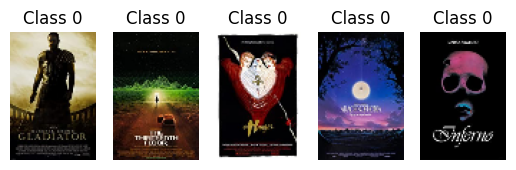

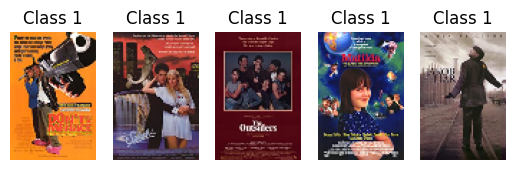

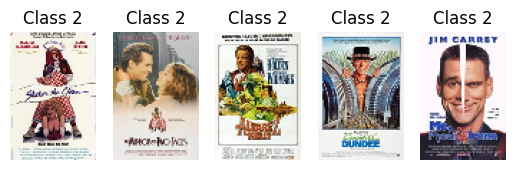

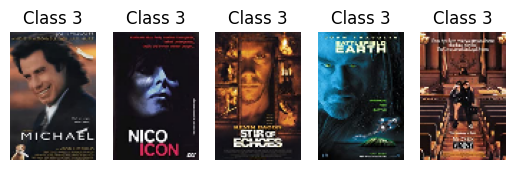

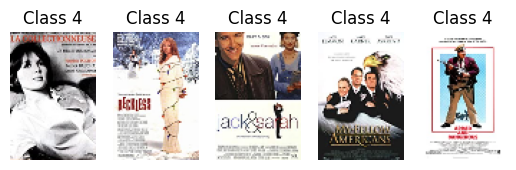

In [45]:
import matplotlib.pyplot as plt
# 打印每个类别的代表性图像
for i, indices in enumerate(representative_images):
    # 设置图像的大小
    for j, index in enumerate(indices):
        # 读取代表性图像
        representative_image_path = os.path.join(folder_path, os.listdir(folder_path)[index])
        representative_image = cv2.imread(representative_image_path)
        representative_image = cv2.resize(representative_image, (60, 90))
        # 绘制图像
        plt.subplot(1, 5, j+1)
        plt.imshow(cv2.cvtColor(representative_image, cv2.COLOR_BGR2RGB))
        plt.title("Class {}".format(i))
        plt.axis("off")

    plt.show()


### 有监督聚类

In [46]:
import pandas as pd

# 读取CSV文件
movies_df = pd.read_csv("./movies.csv")

# 提取genre信息
genres = movies_df['genres']
# 初始化genre的字典
genre_dict = {}

# 遍历每个电影的genre信息
for genre_string in genres:
    # 将genre字符串按照"|"分割成列表
    genre_list = genre_string.split("|")
    # 遍历列表中的每个genre
    for genre in genre_list:
        # 将genre添加到字典中，如果已存在则不重复添加
        if genre not in genre_dict:
            genre_dict[genre] = len(genre_dict)

# 输出genre字典
print("Genre Dictionary:")
print(genre_dict)

Genre Dictionary:
{'Animation': 0, "Children's": 1, 'Comedy': 2, 'Adventure': 3, 'Fantasy': 4, 'Romance': 5, 'Drama': 6, 'Action': 7, 'Crime': 8, 'Thriller': 9, 'Horror': 10, 'Sci-Fi': 11, 'Documentary': 12, 'War': 13, 'Musical': 14, 'Mystery': 15, 'Film-Noir': 16, 'Western': 17}


In [47]:
# 将genre信息转换为向量形式
genre_vectors = []

# 遍历每个电影的genre信息
for genre_string in genres:
    # 将genre字符串按照"|"分割成列表
    genre_list = genre_string.split("|")
    # 初始化genre向量
    genre_vector = [0] * len(genre_dict)
    # 根据genre列表设置向量中对应的位置为1
    for genre in genre_list:
        genre_vector[genre_dict[genre]] = 1
    # 将genre向量添加到列表中
    genre_vectors.append(genre_vector)

# 将genre向量转换为列表
genre_lists = [list(genre_vector) for genre_vector in genre_vectors]

# 将genre列表添加到movies_df中
movies_df['genre_vector'] = genre_lists

# 输出带有genre向量的movies_df
print("Movies DataFrame with Genre Vector:")
display(movies_df.head())

Movies DataFrame with Genre Vector:


Unnamed: 0  movie_id                               title  \
0           0         1                    Toy Story (1995)   
1           1         2                      Jumanji (1995)   
2           2         3             Grumpier Old Men (1995)   
3           3         4            Waiting to Exhale (1995)   
4           4         5  Father of the Bride Part II (1995)   

                         genres  \
0   Animation|Children's|Comedy   
1  Adventure|Children's|Fantasy   
2                Comedy|Romance   
3                  Comedy|Drama   
4                        Comedy   

                                        genre_vector  
0  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [48]:
# 将电影ID列转换为整数类型
movies_df['movie_id'] = movies_df['movie_id'].astype(int)
df['movie_id'] = df['movie_id'].astype(int)

In [49]:
# 使用 merge 方法按照 movie_id 合并两个 DataFrame
# Reading movies info file
movies_info = pd.read_csv('./info.csv',  encoding='latin-1', usecols=['id', 'name', 'genre','intro','directors','starts', 'release_time'])
movies_info.rename(columns ={ 'id':'movie_id', 'starts': 'stars'}, inplace = True)
merged_df = pd.merge(movies_df, df, on='movie_id', how='inner')
merged_df = pd.merge(merged_df, movies_info, on='movie_id', how='inner')
merged_df = merged_df.drop(['Unnamed: 0', 'name', 'genre', 'release_time'], axis=1)

In [50]:
# 输出合并后的 DataFrame
print("Merged DataFrame:")
display(merged_df.head())

Merged DataFrame:


movie_id                               title                        genres  \
0         1                    Toy Story (1995)   Animation|Children's|Comedy   
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy   
2         3             Grumpier Old Men (1995)                Comedy|Romance   
3         4            Waiting to Exhale (1995)                  Comedy|Drama   
4         5  Father of the Bride Part II (1995)                        Comedy   

                                        genre_vector  \
0  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            features  kmeans_cluster  \
0  [1.2273532, 1.1728467, 0.29160947, 3.7952757, ...               1   
1  [1.823149, 0.40036517, 0.5189065, 0.16395436, ...               3   
2  [0.0070503666, 0.7824923, 0.462313, 0.0, 0.418...               3   
3  [0.07367638, 0.3519281, 0.37811843, 0.3463346,...               2   
4  [0.7759676, 1.6042546, 1.2051768, 0.038728412,...               0   

                                               intro        directors  \
0  A cowboy doll is profoundly threatened and jea...    John Lasseter   
1  When two kids find and play a magical board ga...     Joe Johnston   
2  John and Max resolve to save their beloved bai...    Howard Deutch   
3  Based on Terry McMillan's novel, this film fol...  Forest Whitaker   
4  George Banks must deal not only with the pregn...    Charles Shyer   

                                           stars  
0                Tom Hanks|Tim Allen|Don Rickles  
1       Robin Williams|Kirsten Dunst|Bonnie Hunt  
2         Walter Matthau|Jack Lemmon|Ann-Margret  
3  Whitney Houston|Angela Bassett|Loretta Devine  
4         Steve Martin|Diane Keaton|Martin Short

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
from transformers import BertTokenizer, BertModel

In [52]:
# 加载预训练的tokenizer和模型
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [53]:
titles = merged_df['title'].apply(lambda x: x[:-7])
titles = titles.tolist()
# 编码文本
encoded_inputs = tokenizer(titles, padding=True, truncation=True, return_tensors="pt")
# 获取模型输出
with torch.no_grad():
    outputs = model(**encoded_inputs)
# 使用pooler_output作为特征
title_features = outputs.pooler_output

In [54]:
intros = merged_df['intro'].tolist()
# 编码文本
encoded_inputs = tokenizer(intros, padding=True, truncation=True, return_tensors="pt")
# 获取模型输出
with torch.no_grad():
    outputs = model(**encoded_inputs)
# 使用pooler_output作为特征
intro_features = outputs.pooler_output

In [55]:
# 计算每部电影的平均评分和评分数量
ratings = pd.read_csv('./ratings2.csv',  encoding='latin-1', usecols=['user_id', 'movie_id', 'rating', 'timestamp'])
movie_ratings = ratings.groupby('movie_id')['rating'].agg(['mean', 'std', 'count'])

# 将这些特征添加到电影数据中
merged_df = pd.merge(merged_df, movie_ratings, on='movie_id', how='left')

In [56]:
merged_df.head()

movie_id                               title                        genres  \
0         1                    Toy Story (1995)   Animation|Children's|Comedy   
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy   
2         3             Grumpier Old Men (1995)                Comedy|Romance   
3         4            Waiting to Exhale (1995)                  Comedy|Drama   
4         5  Father of the Bride Part II (1995)                        Comedy   

                                        genre_vector  \
0  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            features  kmeans_cluster  \
0  [1.2273532, 1.1728467, 0.29160947, 3.7952757, ...               1   
1  [1.823149, 0.40036517, 0.5189065, 0.16395436, ...               3   
2  [0.0070503666, 0.7824923, 0.462313, 0.0, 0.418...               3   
3  [0.07367638, 0.3519281, 0.37811843, 0.3463346,...               2   
4  [0.7759676, 1.6042546, 1.2051768, 0.038728412,...               0   

                                               intro        directors  \
0  A cowboy doll is profoundly threatened and jea...    John Lasseter   
1  When two kids find and play a magical board ga...     Joe Johnston   
2  John and Max resolve to save their beloved bai...    Howard Deutch   
3  Based on Terry McMillan's novel, this film fol...  Forest Whitaker   
4  George Banks must deal not only with the pregn...    Charles Shyer   

                                           stars      mean       std   count  
0                Tom Hanks|Tim Allen|Don Rickles  4.146846  0.852349  2077.0  
1       Robin Williams|Kirsten Dunst|Bonnie Hunt  3.201141  0.983172   701.0  
2         Walter Matthau|Jack Lemmon|Ann-Margret  3.016736  1.071712   478.0  
3  Whitney Houston|Angela Bassett|Loretta Devine  2.729412  1.013381   170.0  
4         Steve Martin|Diane Keaton|Martin Short  3.006757  1.025086   296.0

In [57]:
rating_features = merged_df[['mean', 'std', 'count']].values

In [58]:
# 提取特征和标签
image_X = merged_df['features'].values.tolist()
intro_X = intro_features
title_X = title_features
rating_X = rating_features
y = np.array(merged_df['genre_vector'].tolist())

# 划分训练集和测试集，注意要使用相同的随机种子以保证划分一致
image_X_train, image_X_test, image_y_train, image_y_test = train_test_split(image_X, y, test_size=0.2, random_state=42)
intro_X_train, intro_X_test, intro_y_train, intro_y_test = train_test_split(intro_X, y, test_size=0.2, random_state=42)
title_X_train, title_X_test, title_y_train, title_y_test = train_test_split(title_X, y, test_size=0.2, random_state=42)
rating_X_train, rating_X_test, rating_y_train, rating_y_test = train_test_split(rating_X, y, test_size=0.2, random_state=42)

In [59]:
# 根据图像特征训练分类器
image_model = XGBClassifier(max_depth=2)
image_model.fit(image_X_train, image_y_train)
image_y_pred = image_model.predict_proba(image_X_test)

In [60]:
# 根据电影简介训练分类器
intro_model = XGBClassifier(max_depth=3)
intro_model.fit(intro_X_train, intro_y_train)
intro_y_pred = intro_model.predict_proba(intro_X_test)

In [61]:
# 根据电影名称训练分类器
title_model = XGBClassifier(max_depth=5)
title_model.fit(title_X_train, title_y_train)
title_y_pred = title_model.predict_proba(title_X_test)

In [62]:
# 根据用户评分情况训练分类器
rating_model = XGBClassifier(max_depth=4)
rating_model.fit(rating_X_train, rating_y_train)
rating_y_pred = rating_model.predict_proba(rating_X_test)

In [63]:
# 对预测结果进行加权，设定阈值得到输出
sum = 1.25 * intro_y_pred + 1 * image_y_pred + 0.5 * title_y_pred + 1.4 * rating_y_pred
maxi = 0
maxi_th = -1
for th in range(0, 5000):
    tmp = (sum > (th / 1000)).astype(int)
    if accuracy_score(image_y_test, tmp) > maxi:
        maxi = accuracy_score(image_y_test, tmp)
        maxi_th = th

y_pred = (sum > maxi_th / 1000).astype(int)

In [64]:
# 评估模型性能
accuracy = accuracy_score(image_y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(image_y_test, y_pred))

Accuracy: 0.23809523809523808
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.03      0.07        29
           1       1.00      0.08      0.15        51
           2       0.58      0.58      0.58       181
           3       0.67      0.04      0.08        49
           4       0.00      0.00      0.00         8
           5       1.00      0.06      0.12        77
           6       0.64      0.80      0.71       251
           7       0.84      0.22      0.35        96
           8       0.00      0.00      0.00        35
           9       0.57      0.05      0.10        73
          10       0.83      0.18      0.29        57
          11       1.00      0.23      0.37        44
          12       0.00      0.00      0.00        11
          13       1.00      0.04      0.07        26
          14       0.00      0.00      0.00        22
          15       0.00      0.00      0.00        18
          16       0.00     